<a href="https://colab.research.google.com/github/GZapulaRT/IC-EMG-Classification/blob/main/EMG_CNN_IC_DB2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tópicos para Artigo:
- Uso de EMG comercial (próteses, controles neurais) (introdutório)
- Interesse público de como deve ser aplicado tais próteses (introdutório)
- Uso de Redes Neurais Convolucionais na área (introdutório)
- Trabalhos de base (metodologia - base)
- ~~NinaPro 2 (metodologia - base) [foco em acurácia e generalização primeiramente?]~~
- NinaPro 5 (metodologia - base) [foco em acurácia e generalização primeiramente?]
- Recortes da base (metodologia - base)
- Janelamento e separação dos dados (metodologia - base)
- Redes Neurais Convolucionais (metodologia - ferramenta)
- Inception, Squeeze and Excitation (metodologia - ferramenta)
- Modelo utilizado & Hiperparâmetros (metodologia - ferramenta)
- Resultados:
  - Inception + SE - Class weight
  - Inception + SE - Sem Class Weight
  - LSTM
  - ResNet 18-50?
- Conclusões
- Trabalhos futuros
  - Outras bases do NinaPro
  - ~~Inserir LSTM para maior robustez de classificação?~~
  - Uso prático da rede para classificação
  - Transformer
  - Melhor de 3 para classificação

## Testar novas redes (**Feito**):
  

- Deixar mais profundo (**Feito**)
  - Mais camadas de convolução (**Feito**)
  - Setar learning rate (**Feito**)
  - Regular os dropouts (**Feito**)
  - Conectar no tensorboard para olhar os valores durante o treinamento (**Feito**)
  - Callback de loss/accuracy após o model.fit() (**Feito**)
  - Separar os dados apropriadamente para o treino (**Feito**)

##Usar todos os parâmetros para treino
Do artigo Finger Movement Regression with Myoelectric 
Signal and Deep Neural Network

*The feature obtained are mean absolute value (MAV), root means square (RMS), waveform length (WFL), integrated absolute value (IAV), zero crossings (ZC), dan slope sign change (SSC).*

- MAV
- RMS
- WFL
- IAV
- ZC
- SSC

##Bibliotecas para a Rede Neural

In [ ]:
# !pip install tensorflow==2.2.0.0rc0
# !pip3 install tensorflow-gpu
!pip install tensorflow-addons
!pip install obspy

     |████████████████████████████████| 1.1 MB 23.2 MB/s 
     |████████████████████████████████| 24.7 MB 1.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for obspy: filename=obspy-1.2.2-cp37-cp37m-linux_x86_64.whl size=21667633 sha256=753511a11ae9fc9e8f4a28b8dbf062cc075e59a9f7accfb2f73816d4df0bd1b4
  Stored in directory: /root/.cache/pip/wheels/28/7e/ea/0a37d5f5001d096cf97d6527b60300badd2d0074449e89c736
Successfully built obspy


In [ ]:
# %load_ext tensorboard.notebook

In [ ]:
# import tensorflow as tf
# import datetime, os

# logs_base_dir = "/content/logs"
# %tensorboard --logdir {logs_base_dir}

In [ ]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import optimizers, initializers
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Dense, Flatten, Input, Activation, PReLU, Convolution1D, MaxPooling1D, Concatenate, Embedding, LeakyReLU, SeparableConv1D
from tensorflow.keras.layers import LSTM, BatchNormalization, Input, AveragePooling2D, Add, TimeDistributed, AveragePooling1D, Lambda, Reshape, GlobalAveragePooling1D, multiply,  GlobalAveragePooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, plot_model, model_to_dot
from tensorflow.keras.callbacks import TensorBoard, Callback, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow_addons.layers import WeightNormalization
from tensorflow.random import set_seed
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from keras import backend as K
from time import time
import six
import math
import h5py
import graphviz
import pydot
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from tensorflow.math import confusion_matrix
import pywt
import numpy as np
from scipy import stats, fft, fftpack
from scipy.signal import filtfilt, firwin, hamming, spectrogram, butter
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from obspy.signal.filter import envelope

Bibliotecas para pegar os arquivos do Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Seed para RNG


In [ ]:
np.random.seed(42)
set_seed(42)

# Funções de acesso a Base de Dados
Obtenção e visualização do NinaPro, e o plot do callback do Keras.


In [ ]:
def getNinaDB(dbPath):
    mat = scipy.io.loadmat(dbPath)

    return mat

def printNinaDB(array):
    print(array)

def plotNinaDB(array):
    input_string = input("Enter a list of indexes to be plotted, separated by space: ")
    indList = [int(sub) for sub in input_string.split()]

    plt.figure(1)
    n = 1
    for i in indList:
        plt.subplot(math.ceil(len(indList)/2), 2, n)
        plt.plot(array[i][1])
        plt.xlabel(array[i][0])
        n += 1

    plt.show()

# Funções para tratamento da Base de Dados

In [ ]:
#input_value = input("Amputee subject number:")
#plotNinaDB(data_db_amp[int(input_value)])

In [ ]:
def subjectData(data_db):
  subjectX = data_db['emg']
  subjectY = data_db['stimulus']
  subjectRep = data_db['repetition']
  # for i in range(subjectX.shape[0]%400):
  #   subjectX = np.delete(subjectX, subjectX.shape[0]-1, 0)
  #   subjectY = np.delete(subjectY, subjectY.shape[0]-1, 0)
  # SampleSubjectX = subjectX.reshape(-1, 400, 12)
  # SampleSubjectY = subjectY.reshape(-1, 400, 1)
  # SampleSubjectY = stats.mode(SampleSubjectY, 1)[0]
  # SampleSubjectY = SampleSubjectY.reshape(-1, 1)

  # print(SampleSubjectX.shape)
  # print(SampleSubjectY.shape)
  # i = 0
  # j = 0
  # values = []
  # while i != 18:
  #   if SampleSubjectY[j][0] == i:
  #     values.append(j)
  #     i += 1
  #   j += 1

  # return SampleSubjectX, subjectY, SampleSubjectY, values
  return subjectX, subjectY, subjectRep

#     Preprocessamento padrão (último decidido em 2020)
def separateData(subjectX, subjectY, subjectRep, filterType = 'None', execGroup = 'All'):
  x_train = []
  x_test = []
  yint_train = []
  yint_test = []

  if execGroup == 'All':
    for i in range(subjectX.shape[0]):
      if subjectRep[i] == 2 or subjectRep[i] == 5:
        x_test.append(subjectX[i])
        yint_test.append(subjectY[i])
      else:
        x_train.append(subjectX[i])
        yint_train.append(subjectY[i])

  elif execGroup == 'A':
    for i in range(subjectX.shape[0]):
      if subjectY[i] < 9:
        if subjectRep[i] == 2 or subjectRep[i] == 5:
          x_test.append(subjectX[i])
          yint_test.append(subjectY[i])
        else:
          x_train.append(subjectX[i])
          yint_train.append(subjectY[i])
          
  elif execGroup == 'B':
    for i in range(subjectX.shape[0]):
      if subjectY[i] == 0 or subjectY[i] > 8:
        if subjectRep[i] == 2 or subjectRep[i] == 5:
          x_test.append(subjectX[i])
          yint_test.append(subjectY[i])
        else:
          x_train.append(subjectX[i])
          yint_train.append(subjectY[i])          

  x_train = np.concatenate((x_train))
  x_train = x_train.reshape(-1, 16)
  x_test = np.concatenate((x_test))
  x_test = x_test.reshape(-1, 16)
  yint_train = np.concatenate((yint_train))
  yint_train = yint_train.reshape(-1, 1)
  yint_test = np.concatenate((yint_test))
  yint_test = yint_test.reshape(-1, 1)

  # np.clip(x_train, -0.002, 0.002, out=x_train)
  # np.clip(x_test, -0.002, 0.002, out=x_test)
  
  if filterType == 'FIRlohi':
    x_train = np.apply_along_axis(filter_signal, 0, x_train, 200, 0.5, 500, 12)
    x_test = np.apply_along_axis(filter_signal, 0, x_test, 200, 0.5, 500, 12)

  elif filterType == 'ButterFilter':
    x_train = np.apply_along_axis(butter_lfilter, 0, x_train, 200, 50, 4)
    x_test = np.apply_along_axis(butter_lfilter, 0, x_test, 200, 50, 4)

  return x_train, x_test, yint_train, yint_test

#     Preprocessamento utilizado no artigo "Gated Recurrent Neural Networks for EMG-Based Hand Gesture"
def separateDataGR(subjectX, subjectY, subjectRep, filterType = 'None', execGroup = 'All'):
  x_train = []
  x_test = []
  yint_train = []
  yint_test = []

  if execGroup == 'All':
    for i in range(subjectX.shape[0]):
      if subjectRep[i] == 2 or subjectRep[i] == 5:
        x_test.append(subjectX[i])
        yint_test.append(subjectY[i])
      else:
        x_train.append(subjectX[i])
        yint_train.append(subjectY[i])

  elif execGroup == 'A':
    for i in range(subjectX.shape[0]):
      if subjectY[i] < 9:
        if subjectRep[i] == 2 or subjectRep[i] == 5:
          x_test.append(subjectX[i])
          yint_test.append(subjectY[i])
        else:
          x_train.append(subjectX[i])
          yint_train.append(subjectY[i])
          
  elif execGroup == 'B':
    for i in range(subjectX.shape[0]):
      if subjectY[i] == 0 or subjectY[i] > 8:
        if subjectRep[i] == 2 or subjectRep[i] == 5:
          x_test.append(subjectX[i])
          yint_test.append(subjectY[i])
        else:
          x_train.append(subjectX[i])
          yint_train.append(subjectY[i])          

  x_train = np.concatenate((x_train))
  x_train = x_train.reshape(-1, 16)
  x_test = np.concatenate((x_test))
  x_test = x_test.reshape(-1, 16)
  yint_train = np.concatenate((yint_train))
  yint_train = yint_train.reshape(-1, 1)
  yint_test = np.concatenate((yint_test))
  yint_test = yint_test.reshape(-1, 1)

  # np.clip(x_train, -0.002, 0.002, out=x_train)
  # np.clip(x_test, -0.002, 0.002, out=x_test)
  
  if filterType == 'FIRlohi':
    x_train = np.apply_along_axis(filter_signal, 0, x_train, 200, 0.5, 500, 12)
    x_test = np.apply_along_axis(filter_signal, 0, x_test, 200, 0.5, 500, 12)

  elif filterType == 'ButterFilter':
    x_train = np.apply_along_axis(butter_lfilter, 0, x_train, 200, 0.5, 4)
    x_test = np.apply_along_axis(butter_lfilter, 0, x_test, 200, 0.5, 4)
    x_train = np.apply_along_axis(abs, 0, x_train)
    x_test = np.apply_along_axis(abs, 0, x_test)
    x_train = np.apply_along_axis(butter_hfilter, 0, x_train, 2000, 500, 4)
    x_test = np.apply_along_axis(butter_hfilter, 0, x_test, 2000, 500, 4)

  x_train = np.apply_along_axis(envelope, 0, x_train)
  x_test = np.apply_along_axis(envelope, 0, x_test)

  return x_train, x_test, yint_train, yint_test

def separateDataFt(subjectX, subjectY, subjectRep, filterType = 'None', execGroup = 'All'):
  x_train = []
  x_test = []
  yint_train = []
  yint_test = []

  if execGroup == 'All':
    for i in range(subjectX.shape[0]):
      if subjectRep[i] == 2 or subjectRep[i] == 5:
        x_test.append(subjectX[i])
        yint_test.append(subjectY[i])
      else:
        x_train.append(subjectX[i])
        yint_train.append(subjectY[i])

  elif execGroup == 'A':
    for i in range(subjectX.shape[0]):
      if subjectY[i] < 9:
        if subjectRep[i] == 2 or subjectRep[i] == 5:
          x_test.append(subjectX[i])
          yint_test.append(subjectY[i])
        else:
          x_train.append(subjectX[i])
          yint_train.append(subjectY[i])
          
  elif execGroup == 'B':
    for i in range(subjectX.shape[0]):
      if subjectY[i] == 0 or subjectY[i] > 8:
        if subjectRep[i] == 2 or subjectRep[i] == 5:
          x_test.append(subjectX[i])
          yint_test.append(subjectY[i])
        else:
          x_train.append(subjectX[i])
          yint_train.append(subjectY[i])          

  x_train = np.concatenate((x_train))
  x_train = x_train.reshape(-1, 16)
  x_test = np.concatenate((x_test))
  x_test = x_test.reshape(-1, 16)
  yint_train = np.concatenate((yint_train))
  yint_train = yint_train.reshape(-1, 1)
  yint_test = np.concatenate((yint_test))
  yint_test = yint_test.reshape(-1, 1)

  # np.clip(x_train, -0.002, 0.002, out=x_train)
  # np.clip(x_test, -0.002, 0.002, out=x_test)

  x_train, x_test, yint_train, yint_test = trim_data(x_train, x_test, yint_train, yint_test, 200)
  x_train, x_test, y_train, y_test = window_data(x_train, x_test, yint_train, yint_test, 200, 25)
  
  if filterType == 'FIRlohi':
    x_train = np.apply_along_axis(filter_signal, 0, x_train, 200, 0.5, 500, 12)
    x_test = np.apply_along_axis(filter_signal, 0, x_test, 200, 0.5, 500, 12)

  elif filterType == 'ButterFilter':
    x_train = np.apply_along_axis(butter_lfilter, 0, x_train, 200, 20, 4)
    x_test = np.apply_along_axis(butter_lfilter, 0, x_test, 200, 20, 4)

  x_train = ext_features(x_train)
  x_test = ext_features(x_test)

  return x_train, x_test, y_train, y_test

# reorderData: Reordena as janelas de sinal obtidos de acordo com a classe do sinal
#     Entrada: x_train: amostras de treino
#              x_test: amostras de teste
#              yint_train: classe das amostras de treino (valor numerico, entrada categórica não permite ordenação)
#              yint_test: classe das amostras de teste (valor numerico, entrada categórica não permite ordenação)
#     Saída: Os valores de entrada, ordenados a partir do valor de classe das amostras

#Não utilizado mais a favor de manter a característica de série temporal
def reorderData(x_train, x_test, yint_train, yint_test):
  reorder_train = yint_train.argsort(axis = 0)
  reorder_test = yint_test.argsort(axis = 0)

  x_train = np.array(x_train)[reorder_train]
  yint_train = np.array(yint_train)[reorder_train].reshape(-1,1)

  x_test = np.array(x_test)[reorder_test]
  yint_test = np.array(yint_test)[reorder_test].reshape(-1,1)

  return x_train, x_test, yint_train, yint_test

# balanceClass0: Reduz o número de
#     Entrada: x_train: amostras de treino
#              x_test: amostras de teste
#              yint_train: classe das amostras de treino (valor numerico)
#              yint_test: classe das amostras de teste (valor numerico)
#     Saída: Valores de entrada com o número de amostras de classe 0 reduzidas

# Uso descontinuado em favor de aplicação de peso reduzido para classe 0
def balanceClass0(x_train, x_test, yint_train, yint_test):
  x_train = np.array(x_train[(np.argmax(yint_train > 0)-np.count_nonzero(yint_train == 1)-400):-1])
  yint_train = np.array(yint_train[(np.argmax(yint_train > 0)-np.count_nonzero(yint_train == 1)-400):-1])

  x_test = np.array(x_test[(np.argmax(yint_test > 0)-np.count_nonzero(yint_test == 1)-400):-1])
  yint_test = np.array(yint_test[(np.argmax(yint_test > 0)-np.count_nonzero(yint_test == 1)-400):-1])

  x_train = x_train.reshape(-1, 16)
  x_test = x_test.reshape(-1, 16)

  return x_train, x_test, yint_train, yint_test

def removeClass0(x_train, x_test, yint_train, yint_test, ordered=True):
  if ordered:
    x_train = np.array(x_train[(np.argmax(yint_train > 0)):-1])
    yint_train = np.array(yint_train[(np.argmax(yint_train > 0)):-1])

    x_test = np.array(x_test[(np.argmax(yint_test == 1)):-1])
    yint_test = np.array(yint_test[(np.argmax(yint_test == 1)):-1])

    x_train = x_train.reshape(-1, 16)
    x_test = x_test.reshape(-1, 16)
  
  else:
    remove_train = yint_train != 0
    remove_test = yint_test != 0

    res_train = [i for i, val in enumerate(remove_train) if val == False]
    res_test = [i for i, val in enumerate(remove_test) if val == False]

    x_train = np.delete(x_train, res_train, 0)
    x_test = np.delete(x_test, res_test, 0)
    
    yint_train = yint_train[remove_train]  
    yint_test = yint_test[remove_test]

  #Reorganizar os valores de y
  yint_train = yint_train-1
  yint_test = yint_test-1

  return x_train, x_test, yint_train, yint_test

def normalizeData(x_train, x_test, typeNorm = 'none'):
  if typeNorm == 'boundNorm':
    x_train /= abs(np.amax(x_train))+abs(np.amin(x_train))/2 + abs(abs(np.amax(x_train))-abs(np.amin(x_train)))/2
    x_test /= abs(np.amax(x_test))+abs(np.amin(x_test))/2 + abs(abs(np.amax(x_test))-abs(np.amin(x_test)))/2
  
  if typeNorm == 'positiveNorm':
    x_train += abs(np.amax(x_train))+abs(np.amin(x_train))/2 + abs(abs(np.amax(x_train))-abs(np.amin(x_train)))/2
    x_train /= (abs(np.amax(x_test))+abs(np.amin(x_test))/2 + abs(abs(np.amax(x_test))-abs(np.amin(x_test)))/2)*2
    x_test += abs(np.amax(x_test))+abs(np.amin(x_test))/2 + abs(abs(np.amax(x_test))-abs(np.amin(x_test)))/2
    x_test /= (abs(np.amax(x_test))+abs(np.amin(x_test))/2 + abs(abs(np.amax(x_test))-abs(np.amin(x_test)))/2)*2

  if typeNorm == 'ampNorm':
    x_train -= np.mean(x_train,axis=0)
    x_train += np.abs(np.amin(x_train,axis=0))
    x_train /= np.std(x_train,axis=0)
    x_train /= np.amax(x_train,axis=0)
    x_test -= np.mean(x_test,axis=0)
    x_test += np.abs(np.amin(x_test,axis=0))
    x_test /= np.std(x_test,axis=0)
    x_test /= np.amax(x_test,axis=0)

  return x_train, x_test

def plotClassHist(subjectY):
  plot = plt.hist(subjectY, bins=18, rwidth=0.8)
  plt.xlim(0,17)
  plt.title("Histograma de distribuição de valores de classe")
  plt.show()

def window(a, window, step, copy = False): # Checar função mais tarde
    sh = (a.size - window + 1, window)
    st = a.strides * 2
    view = np.lib.stride_tricks.as_strided(a, strides = st, shape = sh)[0::step]
    if copy:
        return view.copy()
    else:
        return view

def filter_signal(signal,fs,lowcut,highcut,order):
    nyq = 0.5*fs
    low = lowcut/nyq
    high = highcut/nyq
    fir_coeff = firwin(order+1,[low,high], pass_zero=False)
    return filtfilt(fir_coeff, 1.0, signal)

def butter_lfilter(signal,fs,lowcut, order):
    nyq = 0.5*fs
    low = lowcut/nyq
    b, a = butter(order, low, 'highpass')
    return filtfilt(b, a, signal)

def butter_hfilter(signal,fs,highcut,order):
    nyq = 0.5*fs
    high = highcut/nyq
    b, a = butter(order, high, 'lowpass')
    return filtfilt(b, a, signal)

In [ ]:
def trim_data(x_train, x_test, yint_train, yint_test, window_size = 400):
  x_train = x_train[x_train.shape[0]%window_size::1]
  yint_train = yint_train[yint_train.shape[0]%window_size::1]

  x_test = x_test[x_test.shape[0]%window_size::1]
  yint_test = yint_test[yint_test.shape[0]%window_size::1]

  print(x_train.shape)
  print(yint_train.shape)
  print(x_test.shape)
  print(yint_test.shape)

  return x_train, x_test, yint_train, yint_test

def window_data(x_train, x_test, yint_train, yint_test, window_size = 400, window_stride = 20):
  i = 0
  x_train = np.apply_along_axis(window, 0, x_train, window_size, window_stride)
  yint_train = np.apply_along_axis(window, 0, yint_train, window_size, window_stride)
  while i < yint_train.shape[0]:
    if np.unique((yint_train[i]), axis=0).shape[0] != 1:
      x_train = np.delete(x_train, i, 0)
      yint_train = np.delete(yint_train, i, 0)
    i += 1
  yint_train = stats.mode(yint_train, 1)[0]
  yint_train = yint_train.reshape(-1, 1)
  y_train = to_categorical(yint_train)

  i = 0

  x_test = np.apply_along_axis(window, 0, x_test, window_size, window_stride)
  yint_test = np.apply_along_axis(window, 0, yint_test, window_size, window_stride)
  while i < yint_test.shape[0]:
    if np.unique((yint_test[i]), axis=0).shape[0] != 1:
      x_test = np.delete(x_test, i, 0)
      yint_test = np.delete(yint_test, i, 0)
    i += 1
  yint_test = stats.mode(yint_test, 1)[0]
  yint_test = yint_test.reshape(-1, 1)
  y_test = to_categorical(yint_test)

  print(x_train.shape)
  print(y_train.shape)
  print(x_test.shape)
  print(y_test.shape)

  return x_train, x_test, y_train, y_test

def shuffle_data_windows(x_train, y_train):
  reorder_train = np.arange(x_train.shape[0])
  np.random.shuffle(reorder_train)

  x_train = np.array(x_train)[reorder_train]
  y_train = np.array(y_train)[reorder_train]

  return x_train, y_train

def emg_spectrogram(x_train, x_test):
  x_train = np.swapaxes(spectrogram(x_train, 2e3, axis = 1, window='hamming', noverlap = 184, nfft=256)[2], 2, 3)
  x_test = np.swapaxes(spectrogram(x_test, 2e3, axis = 1, window='hamming', noverlap = 184, nfft=256)[2], 2, 3)

  x_train = x_train[:,:95,:,:]
  x_test = x_test[:,:95,:,:]

  return x_train, x_test

def apply_PCA(x_train, x_test):
  pca = PCA(n_components=25, copy=True)
  x_train = x_train.reshape(12, -1, 95*3)
  x_test = x_test.reshape(12, -1, 95*3)

  xtrain_new = []
  xtest_new = []
  for i in range(12):
    xtrain_new.append(pca.fit_transform(x_train[i]))
    xtest_new.append(pca.fit_transform(x_test[i]))

  x_train = np.concatenate((xtrain_new)).reshape(-1, 5, 5, 12)
  x_test = np.concatenate((xtest_new)).reshape(-1, 5, 5, 12)

  return x_train, x_test

In [ ]:
def plot_conf_matrix(x_test, y_test, num_classes, model):
  labels = list(range(18))
  cm = np.array(confusion_matrix(y_test.argmax(axis=1), (base_model.predict(x_test, 200)>0.5).astype(int).argmax(axis=1)))
  cm = np.true_divide(cm, cm.sum(axis=1, keepdims=True))
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  ax.set_xticks(labels)
  ax.set_yticks(labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 1:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_{}.hd5".format(epoch))

# Funções para extração de Feature

In [ ]:
def ext_features(x, feat = 0):
  if feat == 1 or feat == 0:
    x_aux = np.apply_along_axis(mean_absolute_value, 1, x).reshape(-1, 1, 16) #MAV
  if feat == 2 or feat == 0:
    x_aux = np.concatenate((x_aux, np.apply_along_axis(root_mean_square, 1, x).reshape(-1, 1, 16)), axis=1) #RMS
  if feat == 3 or feat == 0:
    x_aux = np.concatenate((x_aux, np.apply_along_axis(waveform_length, 1, x).reshape(-1, 1, 16)), axis=1) #WFL
  if feat == 4 or feat == 0:
    x_aux = np.concatenate((x_aux, np.apply_along_axis(integrated_absolute_value, 1, x).reshape(-1, 1, 16)), axis=1) #IAV
  if feat == 5 or feat == 0:
    x_aux = np.concatenate((x_aux, np.apply_along_axis(zero_crossing, 1, x).reshape(-1, 1, 16)), axis=1) #ZC
  if feat == 6 or feat == 0:
    x_aux = np.concatenate((x_aux, np.apply_along_axis(slope_sign_change, 1, x).reshape(-1, 1, 16)), axis=1) #SSC
    return x_aux

def mean_absolute_value(x):
    return np.mean(np.absolute(x))

def root_mean_square(x):
    return np.sqrt(np.mean(np.square(x)))

def waveform_length(x):
    diffs = []
    for i in range(len(x)-1):
      diffs.append(abs(x[i] - x[i+1]))
    return np.sum(diffs)

def integrated_absolute_value(x):
    iav = mean_absolute_value(x)*x.size
    return iav

def zero_crossing(x):
    cross = []
    for i in range(len(x)-1):
      if x[i]*x[i+1] < 0 and abs(x[i]-x[i+1]) > 0.01:
        cross.append(1)
      else:
        cross.append(0)
    return np.sum(cross)

def slope_sign_change(x):
    slopeCh = []
    for i in range(1, len(x)-1):
      if x[i] > x[i-1] and x[i] > x[i+1]:
        slopeCh.append(1)
      elif x[i] < x[i-1] and x[i] < x[i+1] and abs(x[i] - x[i+1]) >= 0.01:
        slopeCh.append(1)
      elif abs(x[i]-x[i-1]) >= 0.01:
        slopeCh.append(1)
      else:
        slopeCh.append(0)


# Separar os dados do DB em partes
Separando X e Y em treino, validação e teste, plotando instâncias e histogramas para visibilidade, e testando técnicas de pré-processamento.


- Preparação de dados para indivíduo

In [ ]:
# data_db = []
# data_db = getNinaDB('/content/drive/My Drive/DB Saudavel/DB2_s' + str(sub) + '/S' + str(sub) + '_E1_A1.mat')
# subjectX, subjectY, subjectRep = subjectData()
# sub += 1

In [ ]:
# x_train, x_test, yint_train, yint_test = balanceClass0(*reorderData(*separateData(subjectX, subjectY, subjectRep, filterType = 'FIRlohi')))

- Preparação de dados para toda a base

In [ ]:
# datasetX = []
# datasetY = []
# datasetRep = []

# for i in range(1,41):
#   data_db = []
#   data_db = getNinaDB('/content/drive/My Drive/DB Saudavel/DB2_s' + str(sub) + '/S' + str(sub) + '_E1_A1.mat')
#   subjectX, subjectY, subjectRep = subjectData()
#   datasetX.append(subjectX)
#   datasetY.append(subjectY)
#   datasetRep.append(subjectRep)

# data_db = []
# datasetX = np.concatenate((datasetX))
# datasetY = np.concatenate((datasetY))
# datasetRep = np.concatenate((datasetRep))

# x_train, x_test, yint_train, yint_test = balanceClass0(*reorderData(*separateData(datasetX, datasetY, datasetRep)))

In [ ]:
# plotClassHist(yint_test)

  # Apresentação dos Dados




Plot Individual Puro


In [ ]:
i = 10
data_db = []
data_db = getNinaDB('/content/drive/My Drive/Data DB5/s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
subjectX, subjectY, subjectRep = subjectData(data_db)
x_train, x_test, yint_train, yint_test = separateData(subjectX, subjectY, subjectRep)

print("Unprocessed data")
# for i in range(16):
#   plt.plot(x_train[:,i])
#   plt.show()
C2 = (yint_train == 2)
C8 = (yint_train == 8)

Unprocessed data


Unprocessed data
Eletrodo 1

Classe 2


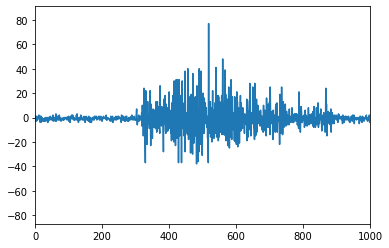


Classe 8


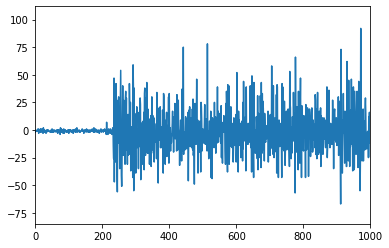

Eletrodo 2

Classe 2


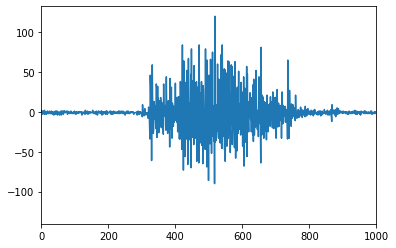


Classe 8


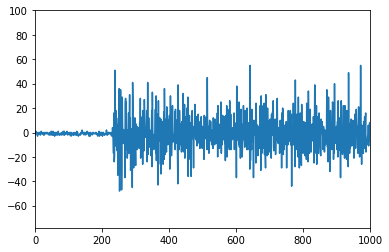

Eletrodo 3

Classe 2


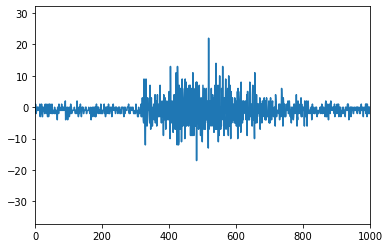


Classe 8


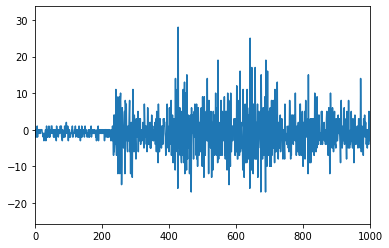

Eletrodo 4

Classe 2


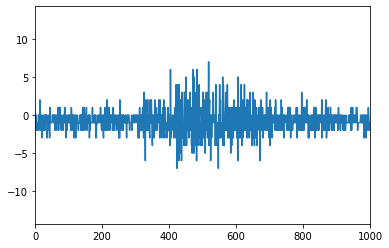


Classe 8


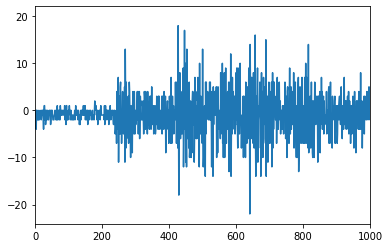

Eletrodo 5

Classe 2


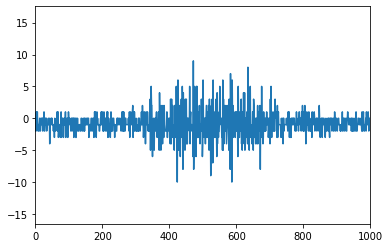


Classe 8


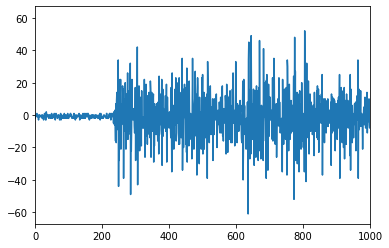

Eletrodo 6

Classe 2


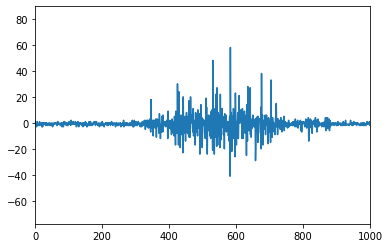


Classe 8


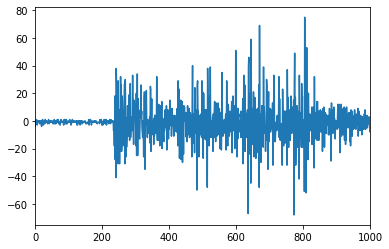

Eletrodo 7

Classe 2


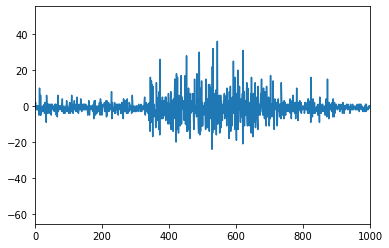


Classe 8


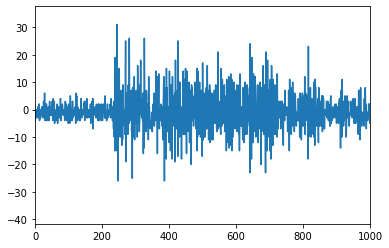

Eletrodo 8

Classe 2


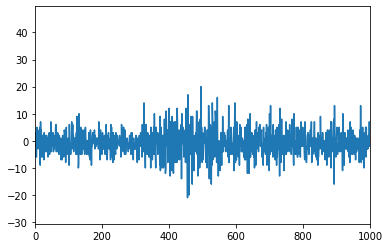


Classe 8


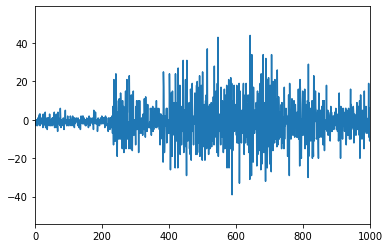

Eletrodo 9

Classe 2


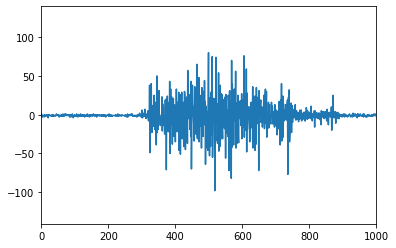


Classe 8


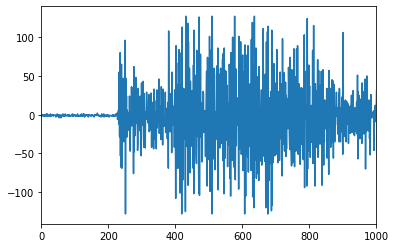

Eletrodo 10

Classe 2


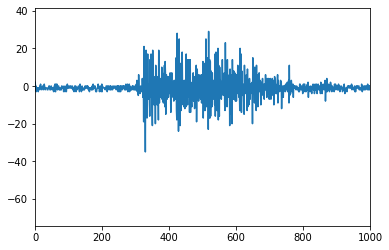


Classe 8


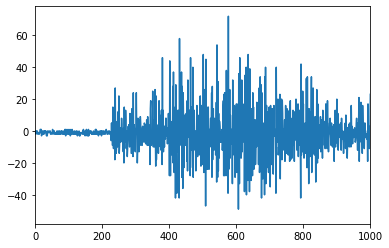

Eletrodo 11

Classe 2


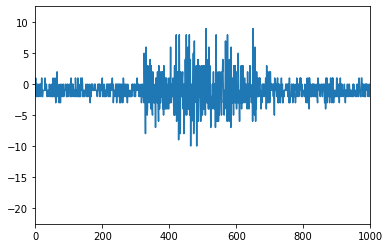


Classe 8


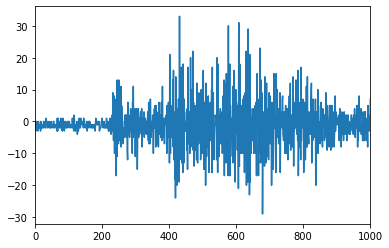

Eletrodo 12

Classe 2


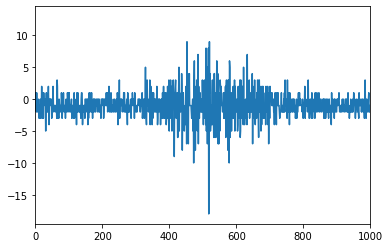


Classe 8


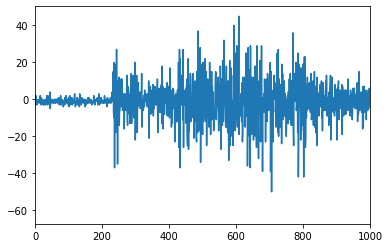

In [ ]:
print("Unprocessed data")
for i in range(12):
  print("Eletrodo " + str(i+1))
  print("\nClasse 2")
  plt.plot(x_train[np.where(C2 == True)[0], i])
  plt.xlim(0, 1000)
  #plt.ylim(-0.0001, 0.0001)
  plt.show()
  print("\nClasse 8")
  plt.plot(x_train[np.where(C8 == True)[0], i])
  plt.xlim(0, 1000)
  #plt.ylim(-0.0001, 0.0001)
  plt.show()

Plot Individual com Filtro

In [ ]:
# i = 5
# window_size = 200
# data_db = []
# data_db = getNinaDB('/content/drive/My Drive/DB Saudavel/DB2_s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
# subjectX, subjectY, subjectRep = subjectData(data_db)

# x_train, x_test, yint_train, yint_test = separateData(subjectX, subjectY, subjectRep)

# plt.plot(x_train.reshape(-1, 12))
# plt.title("No Filter")
# plt.show()
# plt.plot(yint_train)
# plt.show()

# x_train, x_test, yint_train, yint_test = separateData(subjectX, subjectY, subjectRep, filterType = "ButterFilter")

# plt.plot(x_train.reshape(-1, 12))
# plt.title("Butterworth Filter")
# plt.show()
# plt.plot(yint_train)
# plt.show()

Plot individual com cortes

In [ ]:
# i = 5
# window_size = 200
# data_db = []
# data_db = getNinaDB('/content/drive/My Drive/DB Saudavel/DB2_s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
# subjectX, subjectY, subjectRep = subjectData(data_db)

# x_train, x_test, yint_train, yint_test = separateData(subjectX, subjectY, subjectRep, filterType = "ButterFilter")

# x_train, x_test, yint_train, yint_test = removeClass0(x_train, x_test, yint_train, yint_test, ordered=False)

# print("Data with butterworth filter (class 0 removed)")
# plt.plot(x_train.reshape(-1, 12))
# plt.show()
# plt.plot(yint_train)
# plt.show()

# x_train, x_test, yint_train, yint_test = trim_data(x_train, x_test, yint_train, yint_test, window_size)

# print("Data trimmed")
# plt.plot(x_train.reshape(-1, 12))
# plt.show()
# plt.plot(yint_train)
# plt.show()

# x_train, x_test, y_train, y_test = window_data(x_train, x_test, yint_train, yint_test, window_size, 20)

# print("Data windowed")
# plt.plot(x_train.reshape(-1, 12))
# plt.show()
# plt.plot(y_train)
# plt.show()

# x_train = stats.zscore(x_train, 1)
# x_test = stats.zscore(x_test,1)

# print("Data normalized with z-score")
# plt.plot(x_train.reshape(-1, 12))
# plt.show()
# plt.plot(y_train)
# plt.show()

# Modelos de CNN

## Primeiros Modelos

In [ ]:
# model = Sequential()

# model.add(Conv1D(64, kernel_size=21, input_shape=(400,12), name='conv1'))
# model.add(Flatten())
# model.add(Dropout(0.5, name='drop1'))
# model.add(Dense(64, activation='relu',  name='FC1'))
# model.add(Dropout(0.5, name='drop2'))
# model.add(Dense(32, activation='relu', name='FC2'))
# #model.add(Dropout(0.5, name='drop3'))
# model.add(Dense(18, activation='softmax', name='Loss'))

# optim = optimizers.Adam(learning_rate = 0.001)

# model.compile(optimizer = optim, metrics = ['categorical_accuracy'], loss = 'categorical_crossentropy')

# #logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# #tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

# train_history = model.fit(x_train, y_train, batch_size=400, epochs=200)

# test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=400)

# print(train_history)
# print('test_loss: ' + str(test_loss))
# print('test_accuracy: ' + str(test_accuracy))

In [ ]:
# model = Sequential()

# model.add(Conv1D(64, kernel_size=11, input_shape=(400,12), name='conv1'))
# model.add(MaxPool1D(pool_size=2))
# model.add(Dropout(0.5, name='drop1'))
# model.add(Conv1D(128, kernel_size=7, name='conv2'))
# model.add(MaxPool1D(pool_size=2))
# model.add(Conv1D(256, kernel_size=5, name='conv3'))
# model.add(Flatten())
# #model.add(BatchNormalization())
# model.add(Dropout(0.5, name='drop2'))
# model.add(Dense(128, activation='relu', name='FC1'))
# model.add(Dropout(0.5, name='drop3'))
# model.add(Dense(64, activation='relu', name='FC2'))
# model.add(Dropout(0.7, name='drop4'))
# model.add(Dense(32, activation='relu', name='FC3'))
# model.add(Dense(18, activation='softmax', name='Loss'))

# optim = optimizers.Adam(learning_rate = 0.001)

# model.compile(optimizer = optim, metrics = ['categorical_accuracy'], loss = 'categorical_crossentropy')

# #logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# #tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

# train_history = model.fit(x_train, y_train, batch_size=400, epochs=200)

# test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=400)

# print(train_history)
# print('test_loss: ' + str(test_loss))
# print('test_accuracy: ' + str(test_accuracy))

In [ ]:
# model = Sequential()

# model.add(Convolution1D(64, kernel_size=11, input_shape=(600,12), name='Conv1'))
# model.add(MaxPooling1D(pool_size=2, strides=4, name='Pool1'))
# model.add(Convolution1D(128, kernel_size=9, name='Conv2', kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001)))
# model.add(MaxPooling1D(pool_size=2, strides=4, name='Pool2'))
# model.add(Convolution1D(256, kernel_size=9, name='Conv3'))
# model.add(MaxPooling1D(pool_size=2, strides=4, name='Pool3')) 
# #model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(4096, activation='relu', name='FC1'))
# #model.add(Dropout(0.5, name='Drop1'))
# model.add(Dense(4096, activation='relu', name='FC2'))
# #model.add(Dropout(0.5, name='Drop2'))
# model.add(Dense(1024, activation='relu', name='FC3'))
# model.add(Dropout(0.5, name='Drop3'))
# model.add(Dense(512, activation='relu', name='FC4'))
# model.add(Dropout(0.5, name='Drop4'))
# model.add(Dense(256, activation='relu', name='FC5'))
# model.add(Dropout(0.5, name='Drop5'))
# model.add(BatchNormalization())
# model.add(Dense(18, activation='softmax', name='Loss'))

# optim = optimizers.Adam(learning_rate = 0.000876214)

# model.compile(optimizer = optim, metrics = ['categorical_accuracy'], loss = 'categorical_crossentropy')

# #logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# #tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

# train_history = model.fit(x_train, y_train, batch_size=400, epochs=150)

# test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=400)

# print(train_history)
# print('test_loss: ' + str(test_loss))
# print('test_accuracy: ' + str(test_accuracy))

In [ ]:
# model = Sequential()

# model.add(Convolution1D(64, kernel_size=11, input_shape=(600,12), name='Conv1'))
# model.add(MaxPooling1D(pool_size=2, strides=4, name='Pool1'))
# model.add(Convolution1D(128, kernel_size=9, name='Conv2', kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001)))
# model.add(MaxPooling1D(pool_size=2, strides=4, name='Pool2'))
# model.add(Convolution1D(256, kernel_size=9, name='Conv3'))
# #model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=2, strides=4, name='Pool3'))
# model.add(Flatten())
# model.add(Dense(4096, activation='relu', name='FC1'))
# model.add(Dropout(0.5, name='Drop4'))
# model.add(Dense(1024, activation='relu', name='FC2'))
# model.add(Dropout(0.5, name='Drop5'))
# model.add(Dense(256, activation='relu', name='FC3'))
# model.add(Dropout(0.5, name='Drop6'))
# model.add(BatchNormalization())
# model.add(Dense(18, activation='softmax', name='Loss'))

# optim = optimizers.Adam(learning_rate = 0.000676214)

# model.compile(optimizer = optim, metrics = ['categorical_accuracy'], loss = 'categorical_crossentropy')

# #logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# #tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

# train_history = model.fit(x_train, y_train, batch_size=1200, epochs=150)

# test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=400)

# print(train_history)
# print('test_loss: ' + str(test_loss))
# print('test_accuracy: ' + str(test_accuracy))

## Modelos Avançados


###Modelo Inception + SE


In [ ]:
def create_base_model(input_shape, n_classes):

    model = Sequential()
    input_img = Input(shape = input_shape)
    x = Convolution1D(256 , 5, padding='same', activation='relu', name='x' )(input_img)
    # bloco do inception 1D
    conv1_1_1 = Convolution1D(64, 1, padding='same', activation='relu', name='conv1_1_1' )(x)
    conv1_2_1 = Convolution1D(64, 1, padding='same', activation='relu', name='conv1_2_1' )(conv1_1_1)
    conv2_1_1 = Convolution1D(64, 1, padding='same', activation='relu', name='conv2_1_1' )(x)
    conv2_2_1 = Convolution1D(64, 5, padding='same', activation='relu', name='conv2_2_1' )(conv2_1_1)
    conv3_1_1 = MaxPooling1D(pool_size=7, strides=1, padding="same", name='conv3_1_1')(x)
    conv3_2_1 = Convolution1D(64, 1, padding='same', activation='relu', name='conv3_2_1' )(conv3_1_1)
    conv4_1_1 = Convolution1D(64, 1, padding='same', activation='relu', name='conv4_1_1' )(x)
    x2 = Concatenate(axis = 1)([conv1_2_1, conv2_2_1, conv3_2_1, conv4_1_1])
    #drop1 = Dropout(0.5)(x2)
    se1 = SEBlock(se_ratio=1, activation = 'relu', data_format='channels_last')(x2)
    #depthSep = SeparableConv1D(128, kernel_size=5, strides=1, activation='relu')(se1)
    convx1_1 = Convolution1D(64, 7, padding='same', activation='relu', name='convx1_1' )(se1)
    convx1_2 = MaxPooling1D(pool_size=5, strides=1, padding="same", name='convx1_2')(convx1_1)
    # convx1_2 = GlobalAveragePooling1D()(convx1_1)
    outputFlat = Flatten(name='outputFlat')(convx1_2)
    #lstm = LSTM(4)(outputFlat)
    fc1 = Dense(256, activation='relu', name='fc1')(outputFlat)
    drop1 = Dropout(0.5)(fc1)
    fc2 = Dense(64, activation='relu', name='fc2')(drop1)
    drop2 = Dropout(0.5)(fc2)
    # fc3 = Dense(16, activation='relu')(drop2)
    out = Dense(n_classes, activation='softmax', name='out')(drop2)
    model = Model(inputs = input_img, outputs = out)

    return model

def create_base_model2d(input_shape, n_classes):

    model = Sequential()
    input_img = Input(shape = input_shape)
    x = Convolution2D(256 , (5,5), padding='same', activation='relu', name='x' )(input_img)
    # bloco do inception 2D
    conv1_1_1 = Convolution2D(64, (1,1), padding='same', activation='relu', name='conv1_1_1' )(x)
    conv1_2_1 = Convolution2D(64, (1,1), padding='same', activation='relu', name='conv1_2_1' )(conv1_1_1)
    conv2_1_1 = Convolution2D(64, (1,1), padding='same', activation='relu', name='conv2_1_1' )(x)
    conv2_2_1 = Convolution2D(64, (5,5), padding='same', activation='relu', name='conv2_2_1' )(conv2_1_1)
    conv3_1_1 = MaxPooling2D(pool_size=(7,7), strides=(1,1), padding="same", name='conv3_1_1')(x)
    conv3_2_1 = Convolution2D(64, (1,1), padding='same', activation='relu', name='conv3_2_1' )(conv3_1_1)
    conv4_1_1 = Convolution2D(64, (1,1), padding='same', activation='relu', name='conv4_1_1' )(x)
    x2 = Concatenate(axis = 1)([conv1_2_1, conv2_2_1, conv3_2_1, conv4_1_1])
    #drop1 = Dropout(0.5)(x2)
    se1 = SEBlock2D(se_ratio=1, activation = 'relu', data_format='channels_last')(x2)
    #depthSep = SeparableConv1D(128, kernel_size=5, strides=1, activation='relu')(se1)
    convx1_1 = Convolution2D(64, (7,7), padding='same', activation='relu', name='convx1_1' )(se1)
    convx1_2 = MaxPooling2D(pool_size=(5,5), strides=(1,1), padding="same", name='convx1_2')(convx1_1)
    # convx1_2 = GlobalAveragePooling1D()(convx1_1)
    outputFlat = Flatten(name='outputFlat')(convx1_2)
    #lstm = LSTM(4)(outputFlat)
    fc1 = Dense(256, activation='relu', name='fc1')(outputFlat)
    drop1 = Dropout(0.5)(fc1)
    fc2 = Dense(64, activation='relu', name='fc2')(drop1)
    drop2 = Dropout(0.5)(fc2)
    # fc3 = Dense(16, activation='relu')(drop2)
    out = Dense(n_classes, activation='softmax', name='out')(drop2)
    model = Model(inputs = input_img, outputs = out)

    return model

####Bloco Squeeze-and-Excitation

In [ ]:
def SEBlock(se_ratio = 16, activation = "relu", data_format = 'channels_last', ki = "he_normal"):
    '''
    se_ratio : ratio for reduce the filter number of first Dense layer(fc layer) in block
    activation : activation function that of first dense layer
    data_format : channel axis is at the first of dimension or the last
    ki : kernel initializer
    '''

    def f(input_x):

        channel_axis = -1 if data_format == 'channels_last' else 1
        input_channels = input_x.shape[channel_axis]

        reduced_channels = input_channels // se_ratio

        #Squeeze operation
        x = GlobalAveragePooling1D()(input_x)
        x = Reshape(1,1,input_channels)(x) if data_format == 'channels_first' else x
        x = Dense(reduced_channels, kernel_initializer= ki)(x)
        x = Activation(activation)(x)
        #Excitation operation
        x = Dense(input_channels, kernel_initializer=ki, activation='sigmoid')(x)
        x = Permute(dims=(3,1,2))(x) if data_format == 'channels_first' else x
        x = multiply([input_x, x])

        return x

    return f

def SEBlock2D(se_ratio = 16, activation = "relu", data_format = 'channels_last', ki = "he_normal"):
    '''
    se_ratio : ratio for reduce the filter number of first Dense layer(fc layer) in block
    activation : activation function that of first dense layer
    data_format : channel axis is at the first of dimension or the last
    ki : kernel initializer
    '''

    def f(input_x):

        channel_axis = -1 if data_format == 'channels_last' else 1
        input_channels = input_x.shape[channel_axis]

        reduced_channels = input_channels // se_ratio

        #Squeeze operation
        x = GlobalAveragePooling2D()(input_x)
        x = Reshape(1,1,input_channels)(x) if data_format == 'channels_first' else x
        x = Dense(reduced_channels, kernel_initializer= ki)(x)
        x = Activation(activation)(x)
        #Excitation operation
        x = Dense(input_channels, kernel_initializer=ki, activation='sigmoid')(x)
        x = Permute(dims=(3,1,2))(x) if data_format == 'channels_first' else x
        x = multiply([input_x, x])

        return x

    return f

###Modelo Inception para Extração de Feature

In [ ]:
def create_gbase_model(input_shape, n_classes):

    model = Sequential()
    input_img = Input(shape = input_shape)
    x = Convolution1D(256, 5, padding='same', name='x' )(input_img)
    activation1 = Activation(gelu)(x)
    # bloco do inception 1D
    conv1_1_1 = Convolution1D(64, 1, padding='same', name='conv1_1_1' )(x)
    activation2 = Activation(gelu)(conv1_1_1)
    conv1_2_1 = Convolution1D(64, 1, padding='same', name='conv1_2_1' )(conv1_1_1)
    activation3 = Activation(gelu)(conv1_2_1)
    conv2_1_1 = Convolution1D(64, 1, padding='same', name='conv2_1_1' )(x)
    activation4 = Activation(gelu)(conv2_1_1)
    conv2_2_1 = Convolution1D(64, 5, padding='same', name='conv2_2_1' )(conv2_1_1)
    activation5 = Activation(gelu)(conv2_2_1)
    conv3_1_1 = MaxPooling1D(pool_size=7, strides=1, padding="same", name='conv3_1_1')(x)
    conv3_2_1 = Convolution1D(64, 1, padding='same', name='conv3_2_1' )(conv3_1_1)
    activation6 = Activation(gelu)(conv3_2_1)
    conv4_1_1 = Convolution1D(64, 1, padding='same', name='conv4_1_1' )(x)
    activation7 = Activation(gelu)(conv4_1_1)
    x2 = Concatenate(axis = 1)([conv1_2_1, conv2_2_1, conv3_2_1, conv4_1_1])
    #drop1 = Dropout(0.5)(x2)
    # fim do bloco
    # bloco do inception 1D
    # conv1_1_2 = Convolution1D(64, 1, padding='same', activation='relu' )(x2)
    # conv1_2_2 = Convolution1D(64, 1, padding='same', activation='relu' )(conv1_1_2)
    # conv2_1_2 = Convolution1D(64, 1, padding='same', activation='relu' )(x2)
    # conv2_2_2 = Convolution1D(64, 5, padding='same', activation='relu' )(conv2_1_2)
    # conv3_1_2 = MaxPooling1D(pool_size=7, strides=1, padding="same")(x2)
    # conv3_2_2 = Convolution1D(64, 1, padding='same', activation='relu' )(conv3_1_2)
    # conv4_1_2 = Convolution1D(64, 1, padding='same', activation='relu' )(x2)
    # x3 = Concatenate(axis = 1)([conv1_2_2, conv2_2_2, conv3_2_2, conv4_1_2])
    # fim do bloco
    convx1_1 = Convolution1D(64, 7, padding='same', name='convx1_1' )(x2)
    activation8 = Activation(gelu)(convx1_1)
    # convx1_2 = MaxPooling1D(pool_size=5, strides=1, padding="same", name='convx1_2')(convx1_1)
    convx1_2 = GlobalAveragePooling1D()(convx1_1)
    # # bloco do inception 1D
    # conv1_1_3 = Convolution1D(64, 1, padding='same', activation='relu' )(convx1_2)
    # conv1_2_3 = Convolution1D(64, 1, padding='same', activation='relu' )(conv1_1_3)
    # conv2_1_3 = Convolution1D(64, 1, padding='same', activation='relu' )(convx1_2)
    # conv2_2_3 = Convolution1D(64, 5, padding='same', activation='relu' )(conv2_1_3)
    # conv3_1_3 = MaxPooling1D(pool_size=7, strides=1, padding="same")(convx1_2)
    # conv3_2_3 = Convolution1D(64, 1, padding='same', activation='relu' )(conv3_1_3)
    # conv4_1_3 = Convolution1D(64, 1, padding='same', activation='relu' )(convx1_2)
    # x4 = Concatenate(axis = 1)([conv1_2_3, conv2_2_3, conv3_2_3, conv4_1_3])
    # convx2_1 = Convolution1D(64, 7, padding='same', activation='relu' )(x4)
    # output = MaxPooling1D(pool_size=5, strides=1, padding="same")(convx2_1)                        
    # # fim do bloco
    outputFlat = Flatten(name='outputFlat')(convx1_2)
    #lstm = LSTM(4)(outputFlat)
    fc1 = Dense(256, name='fc1')(outputFlat)
    activation9 = Activation(gelu)(fc1)
    drop1 = Dropout(0.5)(fc1)
    fc2 = Dense(64, name='fc2')(drop1)
    activation10 = Activation(gelu)(fc2)
    drop2 = Dropout(0.5)(fc2)
    # fc3 = Dense(16, activation='relu')(drop2)
    out = Dense(n_classes, activation='softmax', name='out')(drop2)
    model = Model(inputs = input_img, outputs = out)

    return model

def gelu(x, beta = 1):
    return (x * K.sigmoid(beta * x))

In [ ]:
def create_feature_model(input_shape):

    model = Sequential()
    input_img = Input(shape = input_shape)
    x = Convolution1D(256, 5, padding='same', activation='relu', name='x' )(input_img)
    # bloco do inception 1D
    conv1_1_1 = Convolution1D(64, 1, padding='same', activation='relu', name='conv1_1_1' )(x)
    conv1_2_1 = Convolution1D(64, 1, padding='same', activation='relu', name='conv1_2_1' )(conv1_1_1)
    conv2_1_1 = Convolution1D(64, 1, padding='same', activation='relu', name='conv2_1_1' )(x)
    conv2_2_1 = Convolution1D(64, 5, padding='same', activation='relu', name='conv2_2_1' )(conv2_1_1)
    conv3_1_1 = MaxPooling1D(pool_size=7, strides=1, padding="same", name='conv3_1_1')(x)
    conv3_2_1 = Convolution1D(64, 1, padding='same', activation='relu', name='conv3_2_1' )(conv3_1_1)
    conv4_1_1 = Convolution1D(64, 1, padding='same', activation='relu', name='conv4_1_1' )(x)
    x2 = Concatenate(axis = 1)([conv1_2_1, conv2_2_1, conv3_2_1, conv4_1_1])
    convx1_1 = Convolution1D(64, 7, padding='same', activation='relu', name='convx1_1' )(x2)
    convx1_2 = MaxPooling1D(pool_size=5, strides=1, padding="same", name='convx1_2')(convx1_1)
    outputFlat = Flatten(name='outputFlat')(convx1_2)
    fc1 = Dense(256, activation='relu', name='fc1')(outputFlat)
    drop1 = Dropout(0.5)(fc1)
    fc2 = Dense(64, activation='relu', name='fc2')(drop1)

    extrator = Model(inputs=input_img, outputs=fc2)

    return extrator

def lstm_feature_model(n_classes):
  model = Sequential()
  input_feat = Input(shape=(64,1))
  lstm = LSTM(4)(input_feat)
  fc1 = Dense(128, activation='relu')(lstm)
  out = Dense(n_classes, activation='softmax')(fc1)

  model = Model(inputs=input_feat, outputs=out)

  return model

###Modelo "Dilated CNN"

In [ ]:
def create_dilated_cnn(input_shape, n_classes):

  model = Sequential()
  input_img = Input(shape = input_shape)
  branch_outputs = []
  for i in range(input_shape[1]):
      # Slicing the ith channel:
      out = Lambda(lambda x : x[:,:,i])(input_img)
      out = Reshape((-1,1))(out)

      # Setting up your per-channel layers (replace with actual sub-models):
      out = Convolution1D(10, 1, padding='valid')(out)
      branch_outputs.append(out)

  out_conc = Concatenate()(branch_outputs)
  # Dilated Convolutional Block
  shortcutConv1 = Convolution1D(64, 1, padding='same')(out_conc)
  conv1 = WeightNormalization(Convolution1D(64, 5, padding='same'))(out_conc)
  act1 = Activation('elu')(conv1)
  convBlock1 = Add()([shortcutConv1, act1])
  # End of Block

  # Identity Block
  conv2 = WeightNormalization(Convolution1D(64, 5, padding='same', dilation_rate = 2)) (convBlock1)
  act2 = Activation('elu')(conv2)
  idBlock1 = Add()([convBlock1, act2])
  # End of Block

  # Dilated Convolutional Block
  shortcutConv2 = Convolution1D(128, 1, padding='same')(idBlock1)
  conv3 = WeightNormalization(Convolution1D(128, 5, padding='same', dilation_rate = 4))(idBlock1)
  act3 = Activation('elu')(conv3)
  convBlock2 = Add()([shortcutConv2, act3])
  # End of Block

  # Identity Block
  conv4 = WeightNormalization(Convolution1D(128, 5, padding='same', dilation_rate = 8)) (convBlock2)
  act4 = Activation('elu')(conv4)
  idBlock2 = Add()([convBlock2, act4])
  # End of Block

  # Dilated Convolutional Block
  shortcutConv3 = Convolution1D(256, 1, padding='same')(idBlock2)
  conv5 = WeightNormalization(Convolution1D(256, 5, padding='same', dilation_rate = 16))(idBlock2)
  act5 = Activation('elu')(conv5)
  convBlock3 = Add()([shortcutConv3, act5])
  # End of Block

  conv6 = Convolution1D(64, 1, padding='same', activation='elu')(convBlock3)
  conv7 = Convolution1D(2, 1, padding='same', activation='elu')(conv6)
  flat = Flatten()(conv7)
  fc = Dense(150, activation='elu')(flat)
  drop = Dropout(0.3)(fc)
  out = Dense(n_classes, activation='softmax')(drop)

  model = Model(inputs = input_img, outputs = out)
  return model

def step_decay(epoch):
	initial_lrate = 0.00005
	drop = 2
	epochs_drop = 10.0
	lrate = (initial_lrate/drop**(math.floor(epoch/epochs_drop)))*(14.4*drop)**math.floor(epoch/100)
	return lrate

###Modelo "Self Recalibrating"

In [ ]:
def create_self_recalibrating_model(input_shape, n_classes):

    model = Sequential()
    input_img = Input(shape = input_shape)
    x = Convolution2D(800, (4,4), padding='valid', activation='relu' )(input_img)
    flat = Flatten()(x)
    fc1 = Dense(800, activation='relu')(flat)
    drop1 = Dropout(0.5)(fc1)
    fc2 = Dense(800, activation='relu')(fc1)
    drop2 = Dropout(0.5)(fc2)
    out = Dense(n_classes, activation='softmax')(fc2)
    model = Model(inputs = input_img, outputs = out)

    return model

###Modelo ResNet

In [ ]:
def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", 1)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Convolution1D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", 1)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Convolution1D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride > 1 or not equal_channels:
        shortcut = Convolution1D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size= 1,
                          strides=stride,
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return Add()([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides =  1
            if i == 0 and not is_first_layer:
                init_strides =  2
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=1, is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Convolution1D(filters=filters, kernel_size= 3,
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size= 3,
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size= 3)(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides= 1, is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Convolution1D(filters=filters, kernel_size=1,
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size= 1,
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=3)(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=1)(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global CHANNEL_AXIS
    ROW_AXIS = 1
    CHANNEL_AXIS = 2


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 2:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows)")

        # Permute dimension order if necessary
        if K.image_data_format() == 'tf':
            input_shape = (input_shape[1], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=7, strides=2)(input)
        pool1 = MaxPooling1D(pool_size=3, strides=2, padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling1D(pool_size=block_shape[ROW_AXIS],
                                 strides=1)(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

##Modelo Simples


In [ ]:
def simple_model(input_shape, n_classes):

    model = Sequential()
    input_img = Input(shape = input_shape)
    x = Convolution1D(64, 15, padding='same', activation='relu' )(input_img)
    pool1 = MaxPooling1D(pool_size=7, strides=1, padding="same" )(x)
    x2 = Convolution1D(128, 11, padding='same', activation='relu' )(pool1)
    x3 = Convolution1D(256, 9, padding='same', activation='relu' )(x2)
    outputFlat = Flatten()(x3)
    #lstm = LSTM(4)(outputFlat)
    fc1 = Dense(128, activation='relu')(outputFlat)
    drop1 = Dropout(0.5)(fc1)
    fc2 = Dense(64, activation='relu')(drop1)
    #drop2 = Dropout(0.5)(fc2)
    #fc3 = Dense(32, activation='relu')(drop2)
    out = Dense(n_classes, activation='softmax')(fc2)
    model = Model(inputs = input_img, outputs = out)

    return model

In [ ]:
# acc = []
# window_size = 400

# fst_sub = 11
# lst_sub = 20
# for i in range(fst_sub, lst_sub+1):
#   data_db = []
#   data_db = getNinaDB('/content/drive/My Drive/DB Saudavel/DB2_s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
#   subjectX, subjectY, subjectRep = subjectData(data_db)

#   x_train, x_test, yint_train, yint_test = separateData(subjectX, subjectY, subjectRep, filterType='ButterFilter', execGroup='A')

#   # x_train, x_test, yint_train, yint_test = balanceClass0(*reorderData(x_train, x_test, yint_train, yint_test))

#   x_train, x_test, yint_train, yint_test = trim_data(x_train, x_test, yint_train, yint_test, window_size)

#   x_train, x_test = normalizeData(x_train, x_test, 'boundNorm')

#   x_train, x_test, y_train, y_test = window_data(x_train, x_test, yint_train, yint_test, window_size, 20)

#   # x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
 
#   lrate = LearningRateScheduler(step_decay)
#   callbacks_list = [lrate]
#   base_model = simple_model(x_train.shape[1:], y_train.shape[1])
#   optim = optimizers.Adam()
#   base_model.compile(loss='categorical_crossentropy',
#                 optimizer=optim,
#                 metrics=["accuracy"])
#   n_epochs = 50
#   batch = 200
#   loss, accuracy, num_parameters = None, None, None
#   class_weight = {
#     0: 0.2,
#     1: 1.0,
#     2: 1.0,
#     3: 1.0,
#     4: 1.0,
#     5: 1.0,
#     6: 1.0,
#     7: 1.0,
#     8: 1.0,
#     9: 1.0,
#     10: 1.0,
#     11: 1.0,
#     12: 1.0,
#     13: 1.0,
#     14: 1.0,
#     15: 1.0,
#     16: 1.0,
#     17: 1.0,
#     18: 1.0,
#   }
#   fit_params = {
#       'x': x_train,
#       'y': y_train,
#       # 'validation_data': (x_val, y_val),
#       'batch_size': batch,
#       'epochs': n_epochs,
#       'class_weight': class_weight,
#       'verbose': 1,
#       'callbacks': callbacks_list,
#       'shuffle': True
#   }
#   # fit_params['validation_data'] = (x_test, y_test)
#   base_model.fit(**fit_params)
#   loss, accuracy = base_model.evaluate(x_test, y_test, verbose=1)
#   num_parameters = base_model.count_params()
#   print('Acc teste = %f' % accuracy)
#   base_model.save_weights("model.h5")
  

#   acc.append(accuracy)
#   K.clear_session()

# print('Acuracias:' + str(acc))
# print('Media das acuracias:' + str(sum(acc)/float((lst_sub+1)-fst_sub)))

In [ ]:
# acc = []
# window_size = 400

# fst_sub = 6
# lst_sub = 6
# for i in range(fst_sub, lst_sub+1):
#   data_db = []
#   data_db = getNinaDB('/content/drive/My Drive/DB Saudavel/DB2_s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
#   subjectX, subjectY, subjectRep = subjectData(data_db)

#   x_train, x_test, yint_train, yint_test = separateData(subjectX, subjectY, subjectRep, filterType='ButterFilter', execGroup='B')

#   # x_train, x_test, yint_train, yint_test = balanceClass0(*reorderData(x_train, x_test, yint_train, yint_test))

#   x_train, x_test, yint_train, yint_test = trim_data(x_train, x_test, yint_train, yint_test, window_size)

#   x_train, x_test = normalizeData(x_train, x_test, 'boundNorm')

#   x_train, x_test, y_train, y_test = window_data(x_train, x_test, yint_train, yint_test, window_size, 20)

#   # x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
 
#   lrate = LearningRateScheduler(step_decay)
#   callbacks_list = [lrate]
#   base_model = simple_model(x_train.shape[1:], y_train.shape[1])
#   optim = optimizers.Adam()
#   base_model.compile(loss='categorical_crossentropy',
#                 optimizer=optim,
#                 metrics=["accuracy"])
#   n_epochs = 50
#   batch = 200
#   loss, accuracy, num_parameters = None, None, None
#   class_weight = {
#     0: 0.2,
#     1: 1.0,
#     2: 1.0,
#     3: 1.0,
#     4: 1.0,
#     5: 1.0,
#     6: 1.0,
#     7: 1.0,
#     8: 1.0,
#     9: 1.0,
#     10: 1.0,
#     11: 1.0,
#     12: 1.0,
#     13: 1.0,
#     14: 1.0,
#     15: 1.0,
#     16: 1.0,
#     17: 1.0,
#     18: 1.0,
#   }
#   fit_params = {
#       'x': x_train,
#       'y': y_train,
#       # 'validation_data': (x_val, y_val),
#       'batch_size': batch,
#       'epochs': n_epochs,
#       'class_weight': class_weight,
#       'verbose': 1,
#       'callbacks': callbacks_list,
#       'shuffle': True
#   }
#   # fit_params['validation_data'] = (x_test, y_test)
#   base_model.fit(**fit_params)
#   loss, accuracy = base_model.evaluate(x_test, y_test, verbose=1)
#   num_parameters = base_model.count_params()
#   print('Acc teste = %f' % accuracy)
#   base_model.save_weights("model.h5")
  

#   acc.append(accuracy)
#   K.clear_session()

# print('Acuracias:' + str(acc))
# print('Media das acuracias:' + str(sum(acc)/float((lst_sub+1)-fst_sub)))

##Treino/Teste do Modelo

###Todos Indivíduos

In [ ]:
# datasetX = []
# datasetY = []
# datasetRep = []

# for i in range(15,17):
#   if i == 4 or i == 13 or i == 22 or i == 25 or i == 26:
#     continue 
#   data_db = []
#   data_db = getNinaDB('/content/drive/My Drive/DB Saudavel/DB2_s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
#   subjectX, subjectY, subjectRep = subjectData(data_db)
#   datasetX.append(subjectX)
#   datasetY.append(subjectY)
#   datasetRep.append(subjectRep)
#   subjectX = []
#   subjectY = []
#   subjectRep = []

In [ ]:
# datasetX = np.concatenate((datasetX))
# datasetY = np.concatenate((datasetY))
# datasetRep = np.concatenate((datasetRep))

In [ ]:
# acc = []
# window_size = 400

# x_train, x_test, yint_train, yint_test = separateDataGR(datasetX, datasetY, datasetRep, filterType='ButterFilter', execGroup='A')

# # x_train, x_test, yint_train, yint_test = balanceClass0(*reorderData(x_train, x_test, yint_train, yint_test))

# x_train, x_test, yint_train, yint_test = trim_data(x_train, x_test, yint_train, yint_test, window_size)

# x_train, x_test = normalizeData(x_train, x_test, 'boundNorm')

In [ ]:
# x_train, x_test, y_train, y_test = window_data(x_train, x_test, yint_train, yint_test, window_size, 20)

# # x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [lrate]
# base_model = create_base_model(x_train.shape[1:], y_train.shape[1])
# optim = optimizers.Adam()
# base_model.compile(loss='categorical_crossentropy',
#               optimizer=optim,
#               metrics=["accuracy"])

In [ ]:
# base_model.load_weights("/content/drive/MyDrive/all_model.h5")

In [ ]:
# n_epochs = 50
# batch = 200
# loss, accuracy, num_parameters = None, None, None
# class_weight = {
#   0: 0.2,
#   1: 1.5,
#   2: 1.5,
#   3: 1.5,
#   4: 1.0,
#   5: 1.0,
#   6: 1.0,
#   7: 1.5,
#   8: 1.0,
#   9: 1.0,
#   10: 1.0,
#   11: 1.0,
#   12: 1.0,
#   13: 1.0,
#   14: 1.0,
#   15: 1.0,
#   16: 1.0,
#   17: 1.0,
#   18: 1.0,
# }
# fit_params = {
#     'x': x_train,
#     'y': y_train,
#     # 'validation_data': (x_val, y_val),
#     'batch_size': batch,
#     'epochs': n_epochs,
#     'class_weight': class_weight,
#     'verbose': 1,
#     'callbacks': callbacks_list,
#     'shuffle': True
# }
# # fit_params['validation_data'] = (x_test, y_test)
# base_model.fit(**fit_params)
# loss, accuracy = base_model.evaluate(x_test, y_test, verbose=1)
# num_parameters = base_model.count_params()
# print('Acc teste = %f' % accuracy)
# base_model.save_weights("/content/drive/MyDrive/all_model.h5")


# acc.append(accuracy)
# K.clear_session()

# print('Acuracias:' + str(acc))


###Indivíduos Separados

Base do NinaPro 2


In [ ]:
acc = []
window_size = 400

fst_sub = 1
lst_sub = 10
for i in range(fst_sub, lst_sub+1):
  data_db = []
  data_db = getNinaDB('/content/drive/My Drive/Data DB2/s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
  subjectX, subjectY, subjectRep = subjectData(data_db)

  x_train, x_test, yint_train, yint_test = separateDataGR(subjectX, subjectY, subjectRep, filterType='ButterFilter', execGroup='All')

  # x_train, x_test, yint_train, yint_test = balanceClass0(*reorderData(x_train, x_test, yint_train, yint_test))

  x_train, x_test, yint_train, yint_test = trim_data(x_train, x_test, yint_train, yint_test, window_size)

  x_train, x_test = normalizeData(x_train, x_test, 'boundNorm')

  x_train, x_test, y_train, y_test = window_data(x_train, x_test, yint_train, yint_test, window_size, 20)

  # x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
 
  #lrate = LearningRateScheduler(step_decay)
  #callbacks_list = [lrate]
  base_model = create_base_model(x_train.shape[1:], y_train.shape[1])
  optim = optimizers.Adadelta()
  base_model.compile(loss='categorical_crossentropy',
                optimizer=optim,
                metrics=["categorical_accuracy"])
  n_epochs = 200
  batch = 256
  loss, accuracy, num_parameters = None, None, None
  class_weight = {
    0: 0.2,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    5: 1.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
    10: 1.0,
    11: 1.0,
    12: 1.0,
    13: 1.0,
    14: 1.0,
    15: 1.0,
    16: 1.0,
    17: 1.0,
    18: 1.0,
  }
  fit_params = {
      'x': x_train,
      'y': y_train,
      # 'validation_data': (x_val, y_val),
      'batch_size': batch,
      'epochs': n_epochs,
      'class_weight': class_weight,
      'verbose': 1,
      #'callbacks': callbacks_list,
      'shuffle': True
  }
  # fit_params['validation_data'] = (x_test, y_test)
  base_model.fit(**fit_params)
  loss, accuracy = base_model.evaluate(x_test, y_test, verbose=1)
  num_parameters = base_model.count_params()
  print('Acc teste = %f' % accuracy)
  base_model.save_weights("model.h5")
  

  acc.append(accuracy)
  K.clear_session()

print('Acuracias:' + str(acc))
print('Media das acuracias:' + str(sum(acc)/float((lst_sub+1)-fst_sub)))

(103200, 16)
(103200, 1)
(26800, 16)
(26800, 1)


KeyboardInterrupt: ignored

In [ ]:
print(acc)

[0.6161261796951294]


Base do NinaPro 5

In [ ]:
acc = []
window_size = 400

fst_sub = 1
lst_sub = 2
for i in range(fst_sub, lst_sub+1):
  data_db = []
  data_db = getNinaDB('/content/drive/My Drive/Data DB5/s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
  subjectX, subjectY, subjectRep = subjectData(data_db)

  x_train, x_test, yint_train, yint_test = separateData(subjectX, subjectY, subjectRep, filterType='ButterFilter', execGroup='A')

  # x_train, x_test, yint_train, yint_test = balanceClass0(*reorderData(x_train, x_test, yint_train, yint_test))

  x_train, x_test, yint_train, yint_test = trim_data(x_train, x_test, yint_train, yint_test, window_size)

  x_train, x_test, y_train, y_test = window_data(x_train, x_test, yint_train, yint_test, window_size, 25)

  x_train, x_test = normalizeData(x_train, x_test, 'boundNorm')

  # x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
 
  #lrate = LearningRateScheduler(step_decay)
  #callbacks_list = [lrate]
  base_model = create_base_model(x_train.shape[1:], y_train.shape[1])
  optim = optimizers.Adadelta()
  base_model.compile(loss='categorical_crossentropy',
                optimizer=optim,
                metrics=["categorical_accuracy"])
  n_epochs = 200
  batch = 32
  loss, accuracy, num_parameters = None, None, None
  class_weight = {
    0: 0.2,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    5: 1.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
    10: 1.0,
    11: 1.0,
    12: 1.0,
    13: 1.0,
    14: 1.0,
    15: 1.0,
    16: 1.0,
    17: 1.0,
    18: 1.0,
  }
  fit_params = {
      'x': x_train,
      'y': y_train,
      # 'validation_data': (x_val, y_val),
      'batch_size': batch,
      'epochs': n_epochs,
      'class_weight': class_weight,
      'verbose': 1,
      #'callbacks': callbacks_list,
      'shuffle': True
  }
  # fit_params['validation_data'] = (x_test, y_test)
  base_model.fit(**fit_params)
  loss, accuracy = base_model.evaluate(x_test, y_test, verbose=1)
  num_parameters = base_model.count_params()
  print('Acc teste = %f' % accuracy)
  base_model.save_weights("model.h5")
  

  acc.append(accuracy)
  K.clear_session()

print('Acuracias:' + str(acc))
print('Media das acuracias:' + str(sum(acc)/float((lst_sub+1)-fst_sub)))

(85200, 16)
(85200, 1)
(17600, 16)
(17600, 1)
(2881, 400, 16)
(2881, 9)
(633, 400, 16)
(633, 9)
Epoch 1/200
91/91 [==============================] - 4s 28ms/step - loss: 1.1571 - categorical_accuracy: 0.0576
Epoch 2/200
91/91 [==============================] - 2s 27ms/step - loss: 1.1569 - categorical_accuracy: 0.0670
Epoch 3/200
91/91 [==============================] - 2s 27ms/step - loss: 1.1568 - categorical_accuracy: 0.0791
Epoch 4/200
91/91 [==============================] - 2s 27ms/step - loss: 1.1567 - categorical_accuracy: 0.0809
Epoch 5/200
91/91 [==============================] - 2s 27ms/step - loss: 1.1566 - categorical_accuracy: 0.0930
Epoch 6/200
91/91 [==============================] - 2s 27ms/step - loss: 1.1563 - categorical_accuracy: 0.1031
Epoch 7/200
91/91 [==============================] - 2s 27ms/step - loss: 1.1562 - categorical_accuracy: 0.1204
Epoch 8/200
91/91 [==============================] - 2s 27ms/step - loss: 1.1561 - categorical_accuracy: 0.1472
Epoch 9/

Acuracias:[0.09022268652915955, 0.08620970696210861, 0.09779894351959229, 0.09321606159210205, 0.08589202165603638]
Media das acuracias:0.09066788405179978

#Modelos SNN

##Modelo Features

In [ ]:
def feature_model(input_shape, n_classes):

    model = Sequential()
    input_img = Input(shape = input_shape)
    x = Dense(128, activation='relu' )(input_img)
    x2 = Dense(64, activation='relu')(x)
    x3 = Dense(32, activation='relu')(x2)
    x4 = Dense(16, activation='relu')(x3)
    out = Dense(n_classes, activation='softmax')(x4)
    model = Model(inputs = input_img, outputs = out)

    return model

## Treino e Teste do Modelo (DB5)

In [ ]:
acc = []
window_size = 200

fst_sub = 8
lst_sub = 10
for i in range(fst_sub, lst_sub+1):
  data_db = []
  data_db = getNinaDB('/content/drive/My Drive/Data DB5/s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
  subjectX, subjectY, subjectRep = subjectData(data_db)

  x_train, x_test, y_train, y_test = separateData(subjectX, subjectY, subjectRep, execGroup='A')

  x = np.concatenate((x_train, x_test), axis=0)
  y = np.concatenate((y_train, y_test), axis=0)

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  base_model = feature_model(x_train.shape[1:], y_train.shape[1])
  optim = optimizers.Adadelta()
  base_model.compile(loss='mse',
                optimizer=optim,
                metrics=["mse"])
  n_epochs = 100
  batch = 32
  loss, accuracy, num_parameters = None, None, None
  class_weight = {
    0: 0.2,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    5: 1.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
    10: 1.0,
    11: 1.0,
    12: 1.0,
    13: 1.0,
    14: 1.0,
    15: 1.0,
    16: 1.0,
    17: 1.0,
    18: 1.0,
  }
  fit_params = {
      'x': x_train,
      'y': y_train,
      # 'validation_data': (x_val, y_val),
      'batch_size': batch,
      'epochs': n_epochs,
      #'class_weight': class_weight,
      'verbose': 1,
      #'callbacks': callbacks_list,
      'shuffle': True
  }
  # fit_params['validation_data'] = (x_test, y_test)
  base_model.fit(**fit_params)
  loss, accuracy = base_model.evaluate(x_test, y_test, verbose=1)
  num_parameters = base_model.count_params()
  print('Acc teste = %f' % accuracy)
  base_model.save_weights("ft_model.h5")
  

  acc.append(accuracy)
  K.clear_session()

print('MSE:' + str(acc))
print('Media das MSE:' + str(sum(acc)/float((lst_sub+1)-fst_sub)))

Epoch 1/100
2940/2940 [==============================] - 13s 4ms/step - loss: 9.5130 - mse: 9.5130
Epoch 2/100
2940/2940 [==============================] - 10s 4ms/step - loss: 9.5130 - mse: 9.5130
Epoch 3/100
2940/2940 [==============================] - 10s 4ms/step - loss: 9.5130 - mse: 9.5130
Epoch 4/100
2940/2940 [==============================] - 10s 4ms/step - loss: 9.5130 - mse: 9.5130
Epoch 5/100
2940/2940 [==============================] - 10s 4ms/step - loss: 9.5130 - mse: 9.5130
Epoch 6/100
2940/2940 [==============================] - 10s 4ms/step - loss: 9.5130 - mse: 9.5130
Epoch 7/100
2940/2940 [==============================] - 10s 4ms/step - loss: 9.5130 - mse: 9.5130
Epoch 8/100
2940/2940 [==============================] - 10s 3ms/step - loss: 9.5130 - mse: 9.5130
Epoch 9/100
2940/2940 [==============================] - 10s 4ms/step - loss: 9.5130 - mse: 9.5130
Epoch 10/100
2940/2940 [==============================] - 10s 4ms/step - loss: 9.5130 - mse: 9.5130
Epoch 11/

MSE:[9.646825790405273, 9.443268775939941, 9.437841415405273, 9.363577842712402, 9.235552787780762, 9.388245582580566, 9.364523887634277, 9.548779487609863, 9.378776550292969, 9.214884757995605]\
Media das MSE:9.472878456115723 (4) + 9.329440752665201 (3) + 9.380813598632812 (3)

#**Acurácias de Teste com Modelo Inception/Squeeze and Excitation**
### **Seed 42**
###Grupo A:
Acurácias:[0.7760416865348816, 0.8433303236961365, 0.6934369802474976, 0.7121848464012146, 0.8256410360336304, 0.14048780500888824, 0.41122448444366455, 0.9093406796455383, 0.9205933809280396, 0.9113697409629822, 0.8970456719398499, 0.6428571343421936, 0.7571297287940979, 0.8648409843444824, 0.6647887229919434, 0.6413662433624268, 0.888170063495636, 0.6860809326171875, 0.2882968485355377, 0.8290945887565613, 0.8279963135719299, 0.80237877368927, 0.8183391094207764, 0.8688245415687561, 0.7526165843009949, 0.758222222328186, 0.9186471700668335, 0.7258567214012146, 0.8714285492897034, 0.7168610692024231, 0.8812785148620605, 0.7108081579208374, 0.7263875603675842, 0.5481798648834229, 0.861629068851471, 0.707556426525116, 0.875, 0.601921021938324, 0.8731883764266968, 0.781619668006897, 0.6374650597572327, 0.678185760974884, 0.9452054500579834]

Com shuffle:

0.03735325485467911, 0.9166666865348816, 0.013648771680891514, 0.8695247173309326, 0.7840172648429871, 0.9571917653083801]

###Grupo B:

Acurácias:[0.9109528064727783, 0.9117379188537598, 0.7859960794448853, 0.7323943376541138, 0.9316163659095764, 0.5606653690338135, 0.7253668904304504, 0.8702090382575989, 0.909246563911438, 0.8635968565940857, 0.6966173648834229, 0.8347193598747253, 0.8702422380447388, 0.734375, 0.8621004819869995, 0.7765505313873291, 0.7067357301712036, 0.798804759979248, 0.7970873713493347, 0.8303821086883545, 0.821626603603363, 0.9099910259246826, 0.8019323945045471, 0.8141762614250183, 0.8494809865951538, 0.7102396488189697, 0.8696051239967346, 0.7057569026947021, 0.7919123768806458, 0.6966966986656189, 0.6803278923034668, 0.8143261075019836, 0.7748478651046753, 0.8168604373931885, 0.6540948152542114, 0.8536585569381714, 0.4791271388530731, 0.6344621777534485, 0.6990394592285156, 0.953687846660614]


{'boxes': [<matplotlib.lines.Line2D at 0x7f20c5969978>,
 'caps': [<matplotlib.lines.Line2D at 0x7f20b46845c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f20c5818a90>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f20c5818390>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f20b4684d68>,
  <matplotlib.lines.Line2D at 0x7f20c5818358>]}

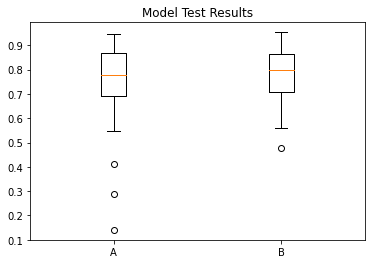

In [ ]:
accA = [0.7760416865348816, 0.8433303236961365, 0.6934369802474976, 0.7121848464012146, 0.8256410360336304, 0.14048780500888824, 0.41122448444366455, 0.9093406796455383, 0.9205933809280396, 0.9113697409629822, 0.8970456719398499, 0.6428571343421936, 0.7571297287940979, 0.8648409843444824, 0.6647887229919434, 0.6413662433624268, 0.888170063495636, 0.6860809326171875, 0.2882968485355377, 0.8290945887565613, 0.8279963135719299, 0.80237877368927, 0.8183391094207764, 0.8688245415687561, 0.7526165843009949, 0.758222222328186, 0.9186471700668335, 0.7258567214012146, 0.8714285492897034, 0.7168610692024231, 0.8812785148620605, 0.7108081579208374, 0.7263875603675842, 0.5481798648834229, 0.861629068851471, 0.707556426525116, 0.875, 0.601921021938324, 0.8731883764266968, 0.781619668006897, 0.6374650597572327, 0.678185760974884, 0.9452054500579834]
accB = [0.9109528064727783, 0.9117379188537598, 0.7859960794448853, 0.7323943376541138, 0.9316163659095764, 0.5606653690338135, 0.7253668904304504, 0.8702090382575989, 0.909246563911438, 0.8635968565940857, 0.6966173648834229, 0.8347193598747253, 0.8702422380447388, 0.734375, 0.8621004819869995, 0.7765505313873291, 0.7067357301712036, 0.798804759979248, 0.7970873713493347, 0.8303821086883545, 0.821626603603363, 0.9099910259246826, 0.8019323945045471, 0.8141762614250183, 0.8494809865951538, 0.7102396488189697, 0.8696051239967346, 0.7057569026947021, 0.7919123768806458, 0.6966966986656189, 0.6803278923034668, 0.8143261075019836, 0.7748478651046753, 0.8168604373931885, 0.6540948152542114, 0.8536585569381714, 0.4791271388530731, 0.6344621777534485, 0.6990394592285156, 0.953687846660614]

data = [accA, accB]
fig1, ax1 = plt.subplots()
plt.xticks(np.arange(0), ['A', 'B'])
ax1.set_title('Model Test Results')
plt.boxplot(data)


#**Acurácias de Teste com Modelo Inception/Squeeze and Excitation, Todos Indivíduos num único treino**
### **Seed 42**
Acuracias:[0.6759793758392334]

In [ ]:
plot_conf_matrix(x_test, y_test, y_test.shape[1], base_model)

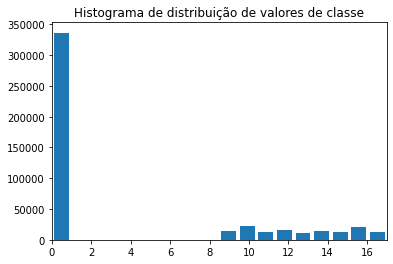

In [ ]:
plotClassHist(yint_test)

## LSTM aplicado para classificação das features extraídas
 - Apredizado rápido, porcentagem próxima do modelo puro

In [ ]:
extractor = create_feature_model(x_train.shape[1:])
extractor.load_weights('model.h5', by_name=True)
features = extractor.predict(x_train)
features_test = extractor.predict(x_test)
lstm_model = lstm_feature_model(y_train.shape[1])

optim = optimizers.Adam(learning_rate=0.001)
lstm_model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=["accuracy"])
n_epochs = 50
batch = 200
loss, accuracy, num_parameters = None, None, None
fit_params = {
    'x': features,
    'y': y_train,
    # 'validation_data': (x_val, y_val),
    'batch_size': batch,
    'epochs': n_epochs,
    'verbose': 1,
    'callbacks': callbacks_list,
    'shuffle': True
}
# fit_params['validation_data'] = (x_test, y_test)
lstm_model.fit(**fit_params)
loss, accuracy = lstm_model.evaluate(features_test, y_test, verbose=1)
num_parameters = lstm_model.count_params()
print('Acc teste = %f' % accuracy)
lstm_model.save_weights("model.h5")

Epoch 1/50
118/118 [==============================] - 0s 4ms/step - loss: 2.7622 - accuracy: 0.1366
Epoch 2/50
118/118 [==============================] - 1s 4ms/step - loss: 2.2054 - accuracy: 0.2575
Epoch 3/50
118/118 [==============================] - 0s 4ms/step - loss: 1.6293 - accuracy: 0.4842
Epoch 4/50
118/118 [==============================] - 1s 4ms/step - loss: 1.1844 - accuracy: 0.6597
Epoch 5/50
118/118 [==============================] - 0s 4ms/step - loss: 0.8562 - accuracy: 0.7801
Epoch 6/50
118/118 [==============================] - 0s 4ms/step - loss: 0.6657 - accuracy: 0.8380
Epoch 7/50
118/118 [==============================] - 1s 4ms/step - loss: 0.5566 - accuracy: 0.8799
Epoch 8/50
118/118 [==============================] - 1s 4ms/step - loss: 0.4842 - accuracy: 0.8911
Epoch 9/50
118/118 [==============================] - 0s 4ms/step - loss: 0.4316 - accuracy: 0.8952
Epoch 10/50
118/118 [==============================] - 0s 4ms/step - loss: 0.3943 - accuracy: 0.8989

## Testados, Resultado Fraco


In [ ]:
acc = []

fst_sub = 5
lst_sub = 5
for i in range(fst_sub, lst_sub+1):
  data_db = []
  data_db = getNinaDB('/content/drive/My Drive/DB Saudavel/DB2_s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
  subjectX, subjectY, subjectRep = subjectData(data_db)

  x_train, x_test, yint_train, yint_test = separateData(subjectX, subjectY, subjectRep, filterType='ButterFilter')

  # x_train, x_test, yint_train, yint_test = balanceClass0(*reorderData(x_train, x_test, yint_train, yint_test))

  x_train, x_test, yint_train, yint_test = trim_data(x_train, x_test, yint_train, yint_test)

  x_train, x_test, y_train, y_test = window_data(x_train, x_test, yint_train, yint_test, 400, 200)

  # x_train, y_train = shuffle_data_windows(x_train, y_train)

  x_train, x_test = emg_spectrogram(x_train, x_test)

  x_train, x_test = normalizeData(x_train, x_test, 'positiveNorm')

  x_train, x_test = apply_PCA(x_train, x_test)

  sr_model = create_self_recalibrating_model(x_train.shape[1:], 18)
  optim = optimizers.Adam(learning_rate = 0.00001)
  sr_model.compile(loss='categorical_crossentropy',
                optimizer=optim,
                metrics=["categorical_accuracy"])
  n_epochs = 200
  batch = 200
  loss, accuracy, num_parameters = None, None, None
  class_weight = {
    0: 0.1,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    5: 1.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
    10: 1.0,
    11: 1.0,
    12: 1.0,
    13: 1.0,
    14: 1.0,
    15: 1.0,
    16: 1.0,
    17: 1.0,
    18: 1.0,
  }
  fit_params = {
      'x': x_train,
      'y': y_train,
      'batch_size': batch,
      'class_weight': class_weight,
      'epochs': n_epochs,
      'verbose': 1,
  }
  # fit_params['validation_data'] = (x_test, y_test)
  sr_model.fit(**fit_params)
  loss, accuracy = sr_model.evaluate(x_test, y_test, verbose=1)
  num_parameters = sr_model.count_params()
  print('Acc teste = %f' % accuracy)
  sr_model.save_weights("model.h5")
  

  acc.append(accuracy)

print('Acuracias:' + str(acc))
print('Media das acuracias:' + str(sum(acc)/float((lst_sub+1)-fst_sub)))

(1206000, 12)
(1206000, 1)
(595200, 12)
(595200, 1)
(5893, 400, 12)
(5893, 18)
(1421, 400, 12)
(1421, 18)
Epoch 1/200
30/30 [==============================] - 0s 3ms/step - loss: 1.3222 - categorical_accuracy: 0.5846
Epoch 2/200
30/30 [==============================] - 0s 3ms/step - loss: 1.3218 - categorical_accuracy: 0.6036
Epoch 3/200
30/30 [==============================] - 0s 3ms/step - loss: 1.3212 - categorical_accuracy: 0.6031
Epoch 4/200
30/30 [==============================] - 0s 3ms/step - loss: 1.3203 - categorical_accuracy: 0.6029
Epoch 5/200
30/30 [==============================] - 0s 3ms/step - loss: 1.3190 - categorical_accuracy: 0.6029
Epoch 6/200
30/30 [==============================] - 0s 3ms/step - loss: 1.3168 - categorical_accuracy: 0.6027
Epoch 7/200
30/30 [==============================] - 0s 3ms/step - loss: 1.3134 - categorical_accuracy: 0.6027
Epoch 8/200
30/30 [==============================] - 0s 3ms/step - loss: 1.3082 - categorical_accuracy: 0.6027
Epoch 

In [ ]:
base_model.fit(**fit_params)
loss, accuracy = base_model.evaluate(x_test, y_test, verbose=1)
num_parameters = base_model.count_params()
print('Acc teste = %f' % accuracy)

In [ ]:
sr_model.fit(**fit_params)
loss, accuracy = sr_model.evaluate(x_test, y_test, verbose=1)
num_parameters = sr_model.count_params()
print('Acc teste = %f' % accuracy)
sr_model.save_weights("model.h5")

In [ ]:
acc = []
window_size = 400

fst_sub = 1
lst_sub = 10
for i in range(fst_sub, lst_sub+1):
  data_db = []
  data_db = getNinaDB('/content/drive/My Drive/DB Saudavel/DB2_s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
  subjectX, subjectY, subjectRep = subjectData(data_db)

  x_train, x_test, yint_train, yint_test = separateData(subjectX, subjectY, subjectRep, filterType='ButterFilter', execGroup='B')

  # x_train, x_test, yint_train, yint_test = balanceClass0(*reorderData(x_train, x_test, yint_train, yint_test))

  x_train, x_test, yint_train, yint_test = trim_data(x_train, x_test, yint_train, yint_test, window_size)

  x_train, x_test = normalizeData(x_train, x_test, 'boundNorm')

  x_train, x_test, y_train, y_test = window_data(x_train, x_test, yint_train, yint_test, window_size, 20)

  # x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

  in_shape = x_train.shape[1:]
  resnet_model = ResnetBuilder.build_resnet_34(in_shape, y_train.shape[1])
  optim = optimizers.Adam(learning_rate = 0.001)
  resnet_model.compile(loss='categorical_crossentropy',
        optimizer=optim,
        metrics=["categorical_accuracy"])
  n_epochs = 50
  batch = 250
  loss, accuracy, num_parameters = None, None, None
  class_weight = {
    0: 0.2,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    5: 1.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
    10: 1.0,
    11: 1.0,
    12: 1.0,
    13: 1.0,
    14: 1.0,
    15: 1.0,
    16: 1.0,
    17: 1.0,
    18: 1.0,
  }
  fit_params = {
      'x': x_train,
      'y': y_train,
      'batch_size': batch,
      'class_weight': class_weight,
      'epochs': n_epochs,
      'verbose': 1,
  }
  # fit_params['validation_data'] = (x_test, y_test)
  resnet_model.fit(**fit_params)
  loss, accuracy = resnet_model.evaluate(x_test, y_test, verbose=1)
  num_parameters = resnet_model.count_params()
  print('Acc teste = %f' % accuracy)
  resnet_model.save_weights("model.h5")

  acc.append(accuracy)

print('Acuracias:' + str(acc))
print('Media das acuracias:' + str(sum(acc)/float((lst_sub+1)-fst_sub)))

(958800, 12)
(958800, 1)
(463200, 12)
(463200, 1)
(47201, 400, 12)
(47201, 18)
(1123, 400, 12)
(1123, 18)
Epoch 1/50
189/189 [==============================] - 18s 93ms/step - loss: 1.4370 - categorical_accuracy: 0.8911
Epoch 2/50
189/189 [==============================] - 17s 92ms/step - loss: 0.6686 - categorical_accuracy: 0.9649
Epoch 3/50
189/189 [==============================] - 17s 92ms/step - loss: 0.4146 - categorical_accuracy: 0.9829
Epoch 4/50
189/189 [==============================] - 17s 92ms/step - loss: 0.3140 - categorical_accuracy: 0.9843
Epoch 5/50
189/189 [==============================] - 17s 92ms/step - loss: 0.2528 - categorical_accuracy: 0.9864
Epoch 6/50
189/189 [==============================] - 17s 92ms/step - loss: 0.2187 - categorical_accuracy: 0.9881
Epoch 7/50
189/189 [==============================] - 17s 92ms/step - loss: 0.1738 - categorical_accuracy: 0.9950
Epoch 8/50
189/189 [==============================] - 17s 92ms/step - loss: 0.1473 - categorical

In [ ]:
acc

[0.8539626002311707,
 0.8334850072860718,
 0.642011821269989,
 0.5926327109336853,
 0.1385435163974762,
 0.5655577182769775,
 0.5859538912773132,
 0.6620209217071533,
 0.8801369667053223,
 0.08340573310852051]

#**Acurácias de Teste com Modelo ResNet-18**
### **Seed 42**
###Grupo A:
Acurácias: [0.7335069179534912, 0.7233661413192749, 0.6986182928085327, 0.6060924530029297, 0.8495726585388184, 0.07902438938617706, 0.15714286267757416, 0.4047619104385376, 0.17713786661624908, 0.8863025903701782, 0.3083900213241577, 0.11223550885915756, 0.03975265100598335, 0.5906103253364563, 0.0958254262804985, 0.19870610535144806, 0.07502467930316925, 0.07421503216028214, 0.7466937899589539, 0.1674290895462036, 0.7629757523536682, 0.8304940462112427, 0.3406279683113098, 0.1635555624961853, 0.9241316318511963, 0.13603322207927704, 0.09642857313156128, 0.7136797308921814, 0.7607305645942688, 0.12074001878499985, 0.4571734368801117, 0.18547596037387848, 0.31501471996307373, 0.8368320465087891, 0.09071505069732666, 0.8541666865348816, 0.722474992275238, 0.07828518003225327, 0.08099351823329926, 0.9049657583236694]

###Grupo B:
Acurácias: [0.845948338508606, 0.8434940576553345, 0.3994082808494568, 0.6803900599479675, 0.08880994468927383, 0.1516634076833725, 0.15828092396259308, 0.8397212624549866, 0.11130136996507645, 0.0686359703540802, 0.29598307609558105, 0.2276507318019867, 0.7612456679344177, 0.6166666746139526, 0.08493150770664215, 0.09175870567560196, 0.6051813364028931, 0.7559760808944702, 0.49708738923072815, 0.07855822890996933, 0.8685868382453918, 0.15942029654979706, 0.2222222238779068, 0.8321799039840698, 0.20261438190937042, 0.12947657704353333, 0.5362473130226135, 0.16175231337547302, 0.32732734084129333, 0.45145145058631897, 0.04303278774023056, 0.5127238631248474, 0.18762677907943726, 0.8110465407371521, 0.3976293206214905, 0.7822299599647522, 0.29791271686553955, 0.07071713358163834, 0.11526147276163101, 0.6672384142875671]


#**Acurácias de Teste com Modelo ResNet-34**
### **Seed 42**
###Grupo A:
Acurácias: [0.7447916865348816, 0.8245300054550171, 0.48100173473358154, 0.11029411852359772, 0.3102564215660095, 0.4419512152671814, 0.5122448801994324, 0.8708791136741638, 0.18411867320537567, 0.08683975040912628, 0.27437642216682434, 0.5400183796882629, 0.8012367486953735, 0.04600938782095909, 0.3349146246910095, 0.12292052060365677, 0.30799606442451477, 0.14938154816627502, 0.7741607427597046, 0.3613906800746918, 0.5467128157615662, 0.8321976065635681, 0.7792578339576721, 0.24799999594688416, 0.0804387554526329, 0.6687434911727905, 0.1517857164144516, 0.5991516709327698, 0.7954338192939758, 0.0613437183201313, 0.22912205755710602, 0.2041216939687729, 0.1000981330871582, 0.2156488597393036, 0.5581643581390381, 0.7509058117866516, 0.5450409650802612, 0.03821062296628952, 0.3574514091014862, 0.8835616707801819]

###Grupo B:
Acurácias:

In [ ]:
acc = []
window_size = 200

fst_sub = 5
lst_sub = 5
for i in range(fst_sub, lst_sub+1):
  data_db = []
  data_db = getNinaDB('/content/drive/My Drive/DB Saudavel/DB2_s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
  subjectX, subjectY, subjectRep = subjectData(data_db)

  x_train, x_test, yint_train, yint_test = separateData(subjectX, subjectY, subjectRep, filterType = "ButterFilter")

  x_train, x_test, yint_train, yint_test = removeClass0(x_train, x_test, yint_train, yint_test, ordered=False)

  x_train, x_test, yint_train, yint_test = trim_data(x_train, x_test, yint_train, yint_test, window_size)

  x_train, x_test, y_train, y_test = window_data(x_train, x_test, yint_train, yint_test, window_size, 20)

  x_train = stats.zscore(x_train, 1)
  x_test = stats.zscore(x_test,1)

  # x_train, x_test = emg_spectrogram(x_train, x_test)

  # x_train, x_test = normalizeData(x_train, x_test, 'positiveNorm')

  # x_train, x_test = apply_PCA(x_train, x_test)


  dc_model = create_dilated_cnn(x_train.shape[1:], y_train.shape[1])
  optim = optimizers.Adam()
  dc_model.compile(loss='categorical_crossentropy',
                optimizer=optim,
                metrics=["categorical_accuracy"])
  n_epochs = 200
  batch = 250
  lrate = LearningRateScheduler(step_decay)
  callbacks_list = [lrate]
  loss, accuracy, num_parameters = None, None, None
  class_weight = {
    0: 0.2,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    5: 1.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
    10: 1.0,
    11: 1.0,
    12: 1.0,
    13: 1.0,
    14: 1.0,
    15: 1.0,
    16: 1.0,
    17: 1.0,
    18: 1.0,
  }
  fit_params = {
      'x': x_train,
      'y': y_train,
      'batch_size': batch,
      'class_weight': class_weight,
      'epochs': n_epochs,
      'verbose': 1,
      'callbacks' : callbacks_list
  }
  # fit_params['validation_data'] = (x_test, y_test)
  dc_model.fit(**fit_params)
  loss, accuracy = dc_model.evaluate(x_test, y_test, verbose=1)
  num_parameters = dc_model.count_params()
  print('Acc teste = %f' % accuracy)
  dc_model.save_weights("model.h5")

  acc.append(accuracy)

print('Acuracias:' + str(acc))
print('Media das acuracias:' + str(sum(acc)/float((lst_sub+1)-fst_sub)))

(481000, 12)
(481000,)
(244800, 12)
(244800,)
(23961, 200, 12)
(23961, 17)
(1208, 200, 12)
(1208, 17)
Epoch 1/200
96/96 [==============================] - 6s 63ms/step - loss: 2.6522 - categorical_accuracy: 0.0909
Epoch 2/200
96/96 [==============================] - 5s 57ms/step - loss: 2.5754 - categorical_accuracy: 0.0949
Epoch 3/200
96/96 [==============================] - 5s 57ms/step - loss: 2.5734 - categorical_accuracy: 0.0944
Epoch 4/200
96/96 [==============================] - 5s 57ms/step - loss: 2.5640 - categorical_accuracy: 0.0977
Epoch 5/200
96/96 [==============================] - 5s 57ms/step - loss: 2.5668 - categorical_accuracy: 0.0969
Epoch 6/200
96/96 [==============================] - 5s 57ms/step - loss: 2.5536 - categorical_accuracy: 0.0997
Epoch 7/200
96/96 [==============================] - 5s 57ms/step - loss: 2.5508 - categorical_accuracy: 0.1002
Epoch 8/200
96/96 [==============================] - 5s 57ms/step - loss: 2.5410 - categorical_accuracy: 0.1043
Ep

In [ ]:
acc = []
window_size = 200

dc_model = create_dilated_cnn(x_train.shape[1:], y_train.shape[1])
optim = optimizers.Adam()
dc_model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=["categorical_accuracy"])

fst_sub = 1
lst_sub = 5
for i in range(fst_sub, lst_sub+1):
  data_db = []
  data_db = getNinaDB('/content/drive/My Drive/DB Saudavel/DB2_s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
  subjectX, subjectY, subjectRep = subjectData(data_db)

  x_train, x_test, yint_train, yint_test = removeClass0(*reorderData(*separateData(subjectX, subjectY, subjectRep, filterType = "ButterFilter")))

  x_train, x_test, yint_train, yint_test = trim_data(x_train, x_test, yint_train, yint_test, window_size)

  x_train, x_test, y_train, y_test = window_data(x_train, x_test, yint_train, yint_test, window_size, 20)

  x_train = stats.zscore(x_train, 1)
  x_test = stats.zscore(x_test,1)

  # x_train, x_test = emg_spectrogram(x_train, x_test)

  # x_train, x_test = normalizeData(x_train, x_test, 'positiveNorm')

  # x_train, x_test = apply_PCA(x_train, x_test)

  n_epochs = 200
  batch = 250
  lrate = LearningRateScheduler(step_decay)
  callbacks_list = [lrate]
  loss, accuracy, num_parameters = None, None, None
  fit_params = {
      'x': x_train,
      'y': y_train,
      'batch_size': batch,
      'epochs': n_epochs,
      'verbose': 1,
      'callbacks' : callbacks_list
  }
  # fit_params['validation_data'] = (x_test, y_test)
  dc_model.fit(**fit_params)
  loss, accuracy = dc_model.evaluate(x_test, y_test, verbose=1)
  num_parameters = dc_model.count_params()
  print('Acc teste = %f' % accuracy)
  dc_model.save_weights("model.h5")

  acc.append(accuracy)

print('Acuracias:' + str(acc))
print('Media das acuracias:' + str(sum(acc)/float((lst_sub+1)-fst_sub)))

In [ ]:
datasetX = []
datasetY = []
datasetRep = []

for i in range(1,41):
  data_db = []
  data_db = getNinaDB('/content/drive/My Drive/DB Saudavel/DB2_s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
  subjectX, subjectY, subjectRep = subjectData(data_db)
  datasetX.append(subjectX)
  datasetY.append(subjectY)
  datasetRep.append(subjectRep)

data_db = []
datasetX = np.concatenate((datasetX))
datasetY = np.concatenate((datasetY))
datasetRep = np.concatenate((datasetRep))

x_train, x_test, yint_train, yint_test = balanceClass0(*reorderData(*separateData(datasetX, datasetY, datasetRep)))

datasetX = []
datasetY = []
datasetRep = []

x_train, x_test, yint_train, yint_test = trim_data(x_train, x_test, yint_train, yint_test)

x_train, x_test, y_train, y_test = window_data(x_train, x_test, yint_train, yint_test, 400, 200)

# x_train, y_train = shuffle_data_windows(x_train, y_train)

x_train, x_test = emg_spectrogram(x_train, x_test)

x_train, x_test = normalizeData(x_train, x_test, 'positiveNorm')

x_train, x_test = apply_PCA(x_train, x_test)

sr_model = create_self_recalibrating_model(x_train.shape[1:], 18)
optim = optimizers.Adam(learning_rate = 0.00001)
sr_model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=["categorical_accuracy"])
n_epochs = 200
batch = 200
loss, accuracy, num_parameters = None, None, None
fit_params = {
    'x': x_train,
    'y': y_train,
    'batch_size': batch,
    'epochs': n_epochs,
    'verbose': 1,
}
# fit_params['validation_data'] = (x_test, y_test)
sr_model.fit(**fit_params)
loss, accuracy = sr_model.evaluate(x_test, y_test, verbose=1)
num_parameters = sr_model.count_params()
print('Acc teste = %f' % accuracy)
sr_model.save_weights("model.h5")

In [ ]:
cm_ytest = np.argmax(y_test, axis = 1)
print(cm_ytest)
cm_ypred = dc_model.predict(x_test)
cm_ypred = np.argmax(cm_ypred, axis = 1)
print(cm_ypred)
print(confusion_matrix(cm_ytest, cm_ypred, normalize='all')*100)

In [ ]:
datasetX = []
datasetY = []
datasetRep = []

window_size = 200

for i in range(1,41):
  data_db = []
  data_db = getNinaDB('/content/drive/My Drive/DB Saudavel/DB2_s' + str(i) + '/S' + str(i) + '_E1_A1.mat')
  subjectX, subjectY, subjectRep = subjectData(data_db)
  datasetX.append(subjectX)
  datasetY.append(subjectY)
  datasetRep.append(subjectRep)

data_db = []
datasetX = np.concatenate((datasetX))
datasetY = np.concatenate((datasetY))
datasetRep = np.concatenate((datasetRep))

x_train, x_test, yint_train, yint_test = balanceClass0(*reorderData(*separateData(datasetX, datasetY, datasetRep, filterType = "ButterFilter")))

datasetX = []
datasetY = []
datasetRep = []

x_train, x_test, yint_train, yint_test = trim_data(x_train, x_test, yint_train, yint_test, window_size)

x_train, x_test, y_train, y_test = window_data(x_train, x_test, yint_train, yint_test, window_size, 20)

x_train = stats.zscore(x_train, 1)
x_test = stats.zscore(x_test,1)

# x_train, y_train = shuffle_data_windows(x_train, y_train)

# x_train, x_test = emg_spectrogram(x_train, x_test)

# x_train, x_test = normalizeData(x_train, x_test, 'positiveNorm')

# x_train, x_test = apply_PCA(x_train, x_test)


dc_model = create_dilated_cnn(x_train.shape[1:], 18)
optim = optimizers.Adam()
dc_model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=["categorical_accuracy"])
n_epochs = 200
batch = 200
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
loss, accuracy, num_parameters = None, None, None
fit_params = {
    'x': x_train,
    'y': y_train,
    'batch_size': batch,
    'epochs': n_epochs,
    'verbose': 1,
    'callbacks' : callbacks_list
}
# fit_params['validation_data'] = (x_test, y_test)
dc_model.fit(**fit_params)
loss, accuracy = dc_model.evaluate(x_test, y_test, verbose=1)
num_parameters = dc_model.count_params()
print('Acc teste = %f' % accuracy)
dc_model.save_weights("model.h5")